<a href="https://colab.research.google.com/github/nitrogenlab/OtherTransects/blob/main/GP02_ThermoclineSplittingDev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gsw
import gsw

In [2]:
#load GP02 data from my Google Drive.
#I uploaded the dataset from the IDP product to Google Drive because
#I couldn't get a direct link to download the data from the IDP website.
#The file is too big to upload to GitHub.
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm" -O IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_D9Myt6WA.csv
#Have to use code below since file is above 100 MB
#https://drive.google.com/file/d/1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm" -O IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_D9Myt6WA.csv && rm -rf /tmp/cookies.txt

--2023-08-13 18:22:05--  https://docs.google.com/uc?export=download&confirm=&id=1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm
Resolving docs.google.com (docs.google.com)... 142.251.161.101, 142.251.161.139, 142.251.161.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.161.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3bhh33laqpqd1okp6liemfc52l0s3up/1691950875000/06203730782251856755/*/1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm?e=download&uuid=fa9fde62-6956-41b4-b2fd-b24fa5014ac5 [following]
--2023-08-13 18:22:06--  https://doc-14-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a3bhh33laqpqd1okp6liemfc52l0s3up/1691950875000/06203730782251856755/*/1r8Xfj6VCdm6QOh0QIlGctoFJ6LdDTBWm?e=download&uuid=fa9fde62-6956-41b4-b2fd-b24fa5014ac5
Resolving doc-14-a4-docs.googleusercontent.com (doc-14-a4-docs.googleusercontent.com)... 172.217.214.1

In [3]:
import pandas as pd
#GP02_df = pd.read_csv('IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_D9Myt6WA.csv',
                   #skiprows=31, skipfooter=3)
#above didn't remove line starting with '//history' in the middle of the file

# We open the source GP02 file and get its lines
with open('IDP2021_GEOTRACES_IDP2021_Seawater_Sensor_Data_v1_D9Myt6WA.csv', 'r') as inp:
    lines = inp.readlines()

# We open the target file in write-mode
with open('purged_csv_file.csv', 'w') as out:
    # We go line by line writing in the target file
    # if the original line does not include the
    # strings 'py-board' or 'coffee'
    for line in lines:
        if line.startswith('//'):
         #print(line)
          continue
        elif '"' in line:
          #print(line)
          continue
        #below did not work to remove the line of code, so removed with skiprows option in pd.read_csv
        #elif line.startswith("//<DataVariable>label="):
          #print("should be data variable",line)
        #elif line.startswith("//<MetaVariable>label="):
          #print("should be meta data",line)
        else:
            out.write(line)
        #if not '//' in line:
            #out.write(line)


In [4]:
col_list=["Station", "Longitude [degrees_east]", "Latitude [degrees_north]", "CTDPRS_T_VALUE_SENSOR [dbar]", "CTDTMP_T_VALUE_SENSOR [deg C]", "CTDSAL_D_CONC_SENSOR [pss-78]"]
GP02_df = pd.read_csv('purged_csv_file.csv', usecols=col_list)
#'skiprows=18' not needed once fixed if statements above
GP02_df.columns=["STNNBR", "lon", "lat", "CTDPRS", "CTDTMP", "CTDSAL"]

In [5]:
#make STNNBR column only station numbers
GP02_df = GP02_df.assign(STNNBR=GP02_df['STNNBR'].str.replace(r'\D', ''))
GP02_df['STNNBR'] = GP02_df['STNNBR'].astype(int)
print(GP02_df['STNNBR'])

<ipython-input-5-7b7f3ec746ba>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  GP02_df = GP02_df.assign(STNNBR=GP02_df['STNNBR'].str.replace(r'\D', ''))


0         10
1         10
2         10
3         10
4         10
          ..
186549     1
186550     1
186551     1
186552     1
186553     1
Name: STNNBR, Length: 186554, dtype: int64


In [6]:
#add bug fix for GSW
import numpy as np
#identify variables that aren't floats
#print(GP02_df.dtypes)
#change lon to float
#GP02_df['lon'] = GP02_df['lon'].astype(float, errors = 'raise')

#add sig0 and depth to dataset
absolute_salinity = np.array(gsw.SA_from_SP(SP=np.array(GP02_df['CTDSAL']),
                                     p=np.array(GP02_df['CTDPRS']),
                                     lon=np.array(GP02_df['lon']),
                                     lat=np.array(GP02_df['lat'])))
conservative_temp = gsw.CT_from_t(SA=np.array(absolute_salinity),
                                    t=np.array(GP02_df["CTDTMP"]), p=np.array(GP02_df["CTDPRS"]))
GP02_df['sig0'] = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
GP02_df['sig0']  = round(GP02_df['sig0'] , 1)

z = gsw.z_from_p(np.array(GP02_df["CTDPRS"]), lat=GP02_df['lat'])
GP02_df['depth'] = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
GP02_df['depth']  = round(GP02_df['depth'] , 1)

In [7]:
GP02_df.STNNBR = GP02_df.STNNBR.astype(float)
GP02_df.CTDPRS = GP02_df.CTDPRS.astype(float)
#df.a = df.a.astype(float)
#make sure data types make sense
print(GP02_df.dtypes)

STNNBR    float64
lon       float64
lat       float64
CTDPRS    float64
CTDTMP    float64
CTDSAL    float64
sig0      float64
depth     float64
dtype: object


In [8]:
#for creating sorted_monotonic_density variable
#getting 'ValueError: Input contains NaN, infinity or a value too large for dtype('float64').'
#Check for NaN's.
print('NaN in entire dataframe', GP02_df.isnull().sum().sum())
print('NaN in depth col',GP02_df['depth'].isnull().sum().sum())
print('NaN in sig0 col',GP02_df['sig0'].isnull().sum().sum())
print('NaN in pressure col',GP02_df['CTDPRS'].isnull().sum().sum())
print('NaN in sal col',GP02_df['CTDSAL'].isnull().sum().sum())
#looks like salinity is causing sig0 to have NaN's
#remove rows with NaN's
GP02_df = GP02_df.dropna(subset=['CTDSAL'])
print('NaN in entire dataframe with sal NaN removed', GP02_df.isnull().sum().sum())
print("Checking number of inf in dataset:",np.isinf(GP02_df).values.sum())

NaN in entire dataframe 48
NaN in depth col 0
NaN in sig0 col 16
NaN in pressure col 0
NaN in sal col 16
NaN in entire dataframe with sal NaN removed 0
Checking number of inf in dataset: 0


In [9]:
#order dataframe by depth
GP02_df=GP02_df.sort_values(by=['STNNBR','depth'])
GP02_df=GP02_df.reset_index(drop=True)
index_drop=[]
#identify unwanted rows because depths not at least one meter apart
#check out https://stackoverflow.com/questions/57636197/scipy-univariatespline-fails-with-multivalued-x
#if want to keep all data
for i, row in GP02_df.iterrows():
  if i==0:
    continue
  elif i==1:
    if GP02_df['depth'][i]-GP02_df['depth'][i-1]>=1:
      continue
    else:
      #GP02_df = GP02_df.drop(i)
      #print(GP02_df['depth'][i]-GP02_df['depth'][i-1])
      index_drop.append(i)
  elif i>1:
    if GP02_df['depth'][i-1]-GP02_df['depth'][i-2]>=1:
      if GP02_df['depth'][i]-GP02_df['depth'][i-1]>=1:
        continue
      else:
        index_drop.append(i)
        #print(GP02_df['depth'][i]-GP02_df['depth'][i-1])
    elif GP02_df['depth'][i]-GP02_df['depth'][i-2]<1:
      index_drop.append(i)
    else:
      continue
  else:
    print("possible error")
    continue


In [10]:
#drop unwanted rows
GP02_df=GP02_df.drop(index_drop)
#reset index
GP02_df=GP02_df.reset_index(drop=True)

Below saving data in names tuples then a dictionary to match required format for this JSON file


In [12]:
from collections import namedtuple
StnData = namedtuple("StnData", ["df", "pressure", "sig0", "depth",
                                 "lat", "lon"])
stations = np.unique(GP02_df['STNNBR'])
stn_to_data = {}

for stn in sorted(stations):
    stn_data = GP02_df[GP02_df['STNNBR']==stn]
    latitude=stn_data.lat
    latitude=latitude.reset_index(drop=True)
    longitude=stn_data.lon
    longitude=longitude.reset_index(drop=True)
    lat=latitude[1]
    lon=longitude[1]
    stn_tuple=StnData(df=stn_data, pressure=stn_data["CTDPRS"], sig0=stn_data["sig0"], depth=stn_data["depth"], lat=lat, lon=lon)

    stn_to_data[stn] = stn_tuple



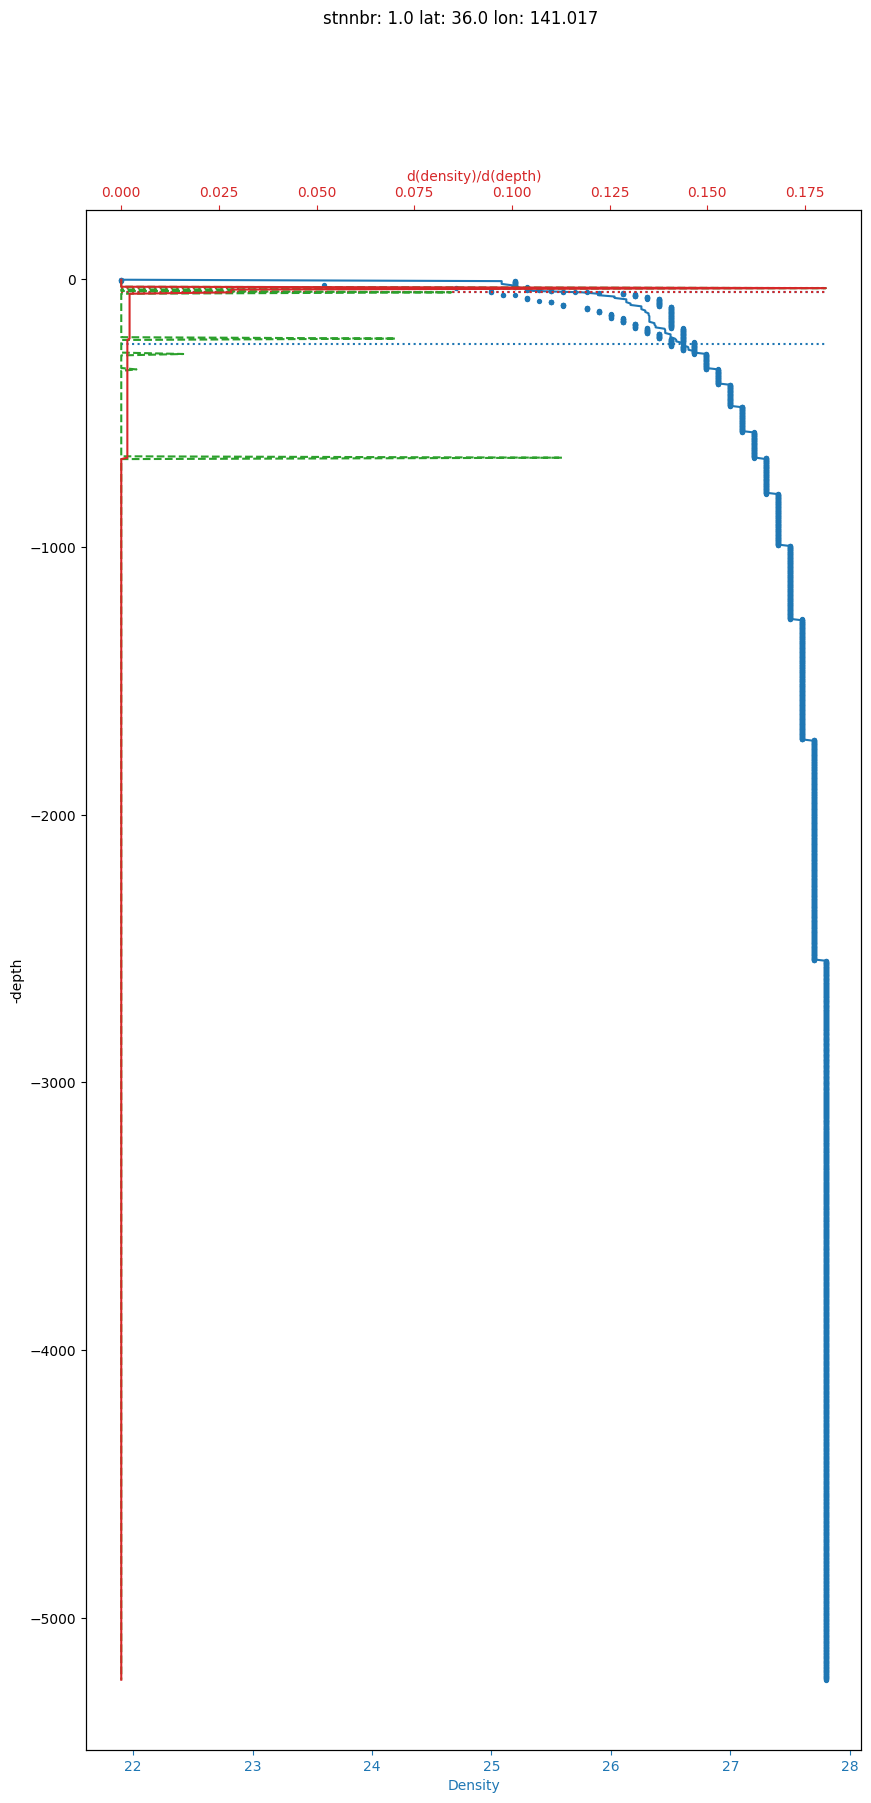

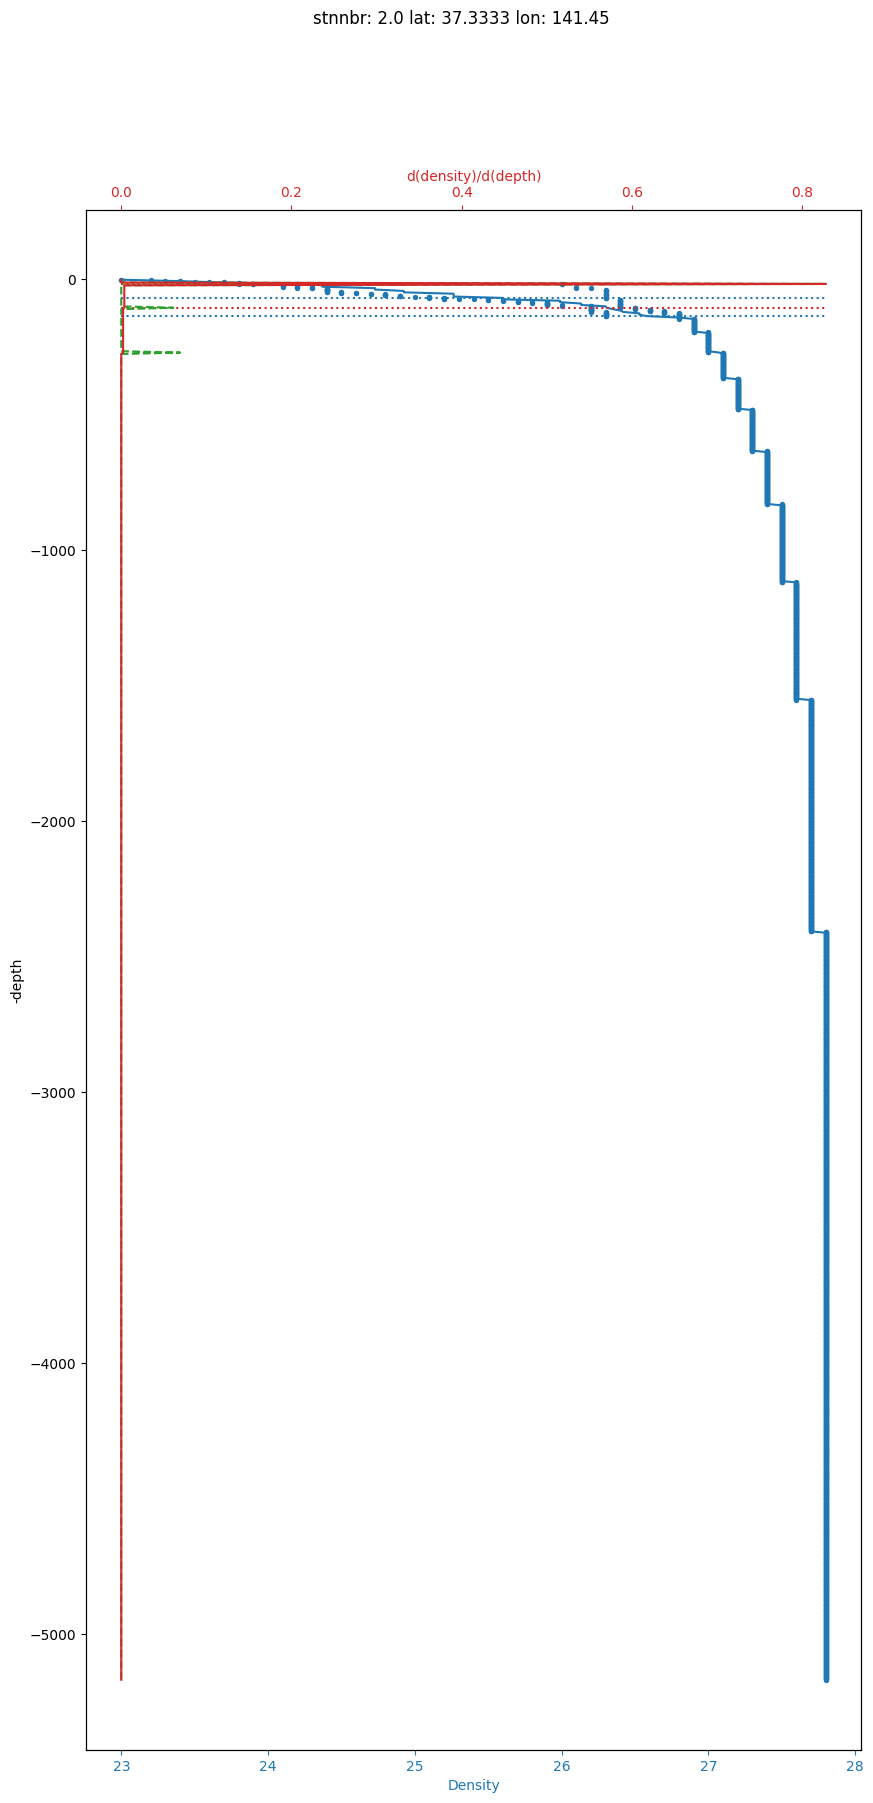

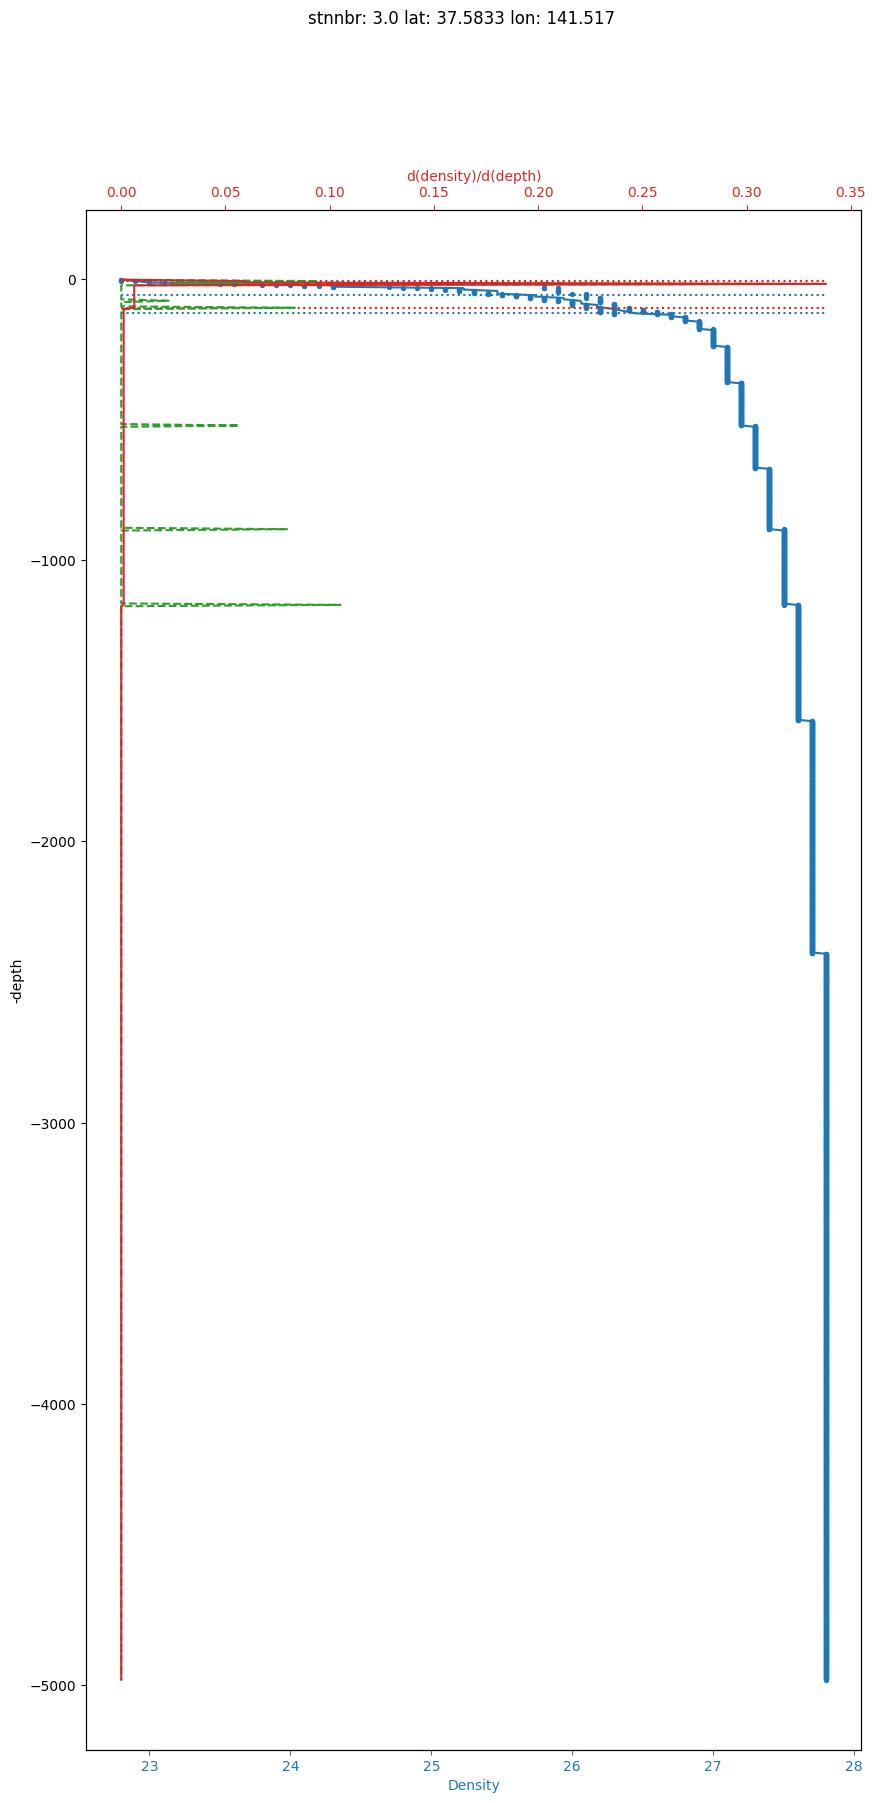

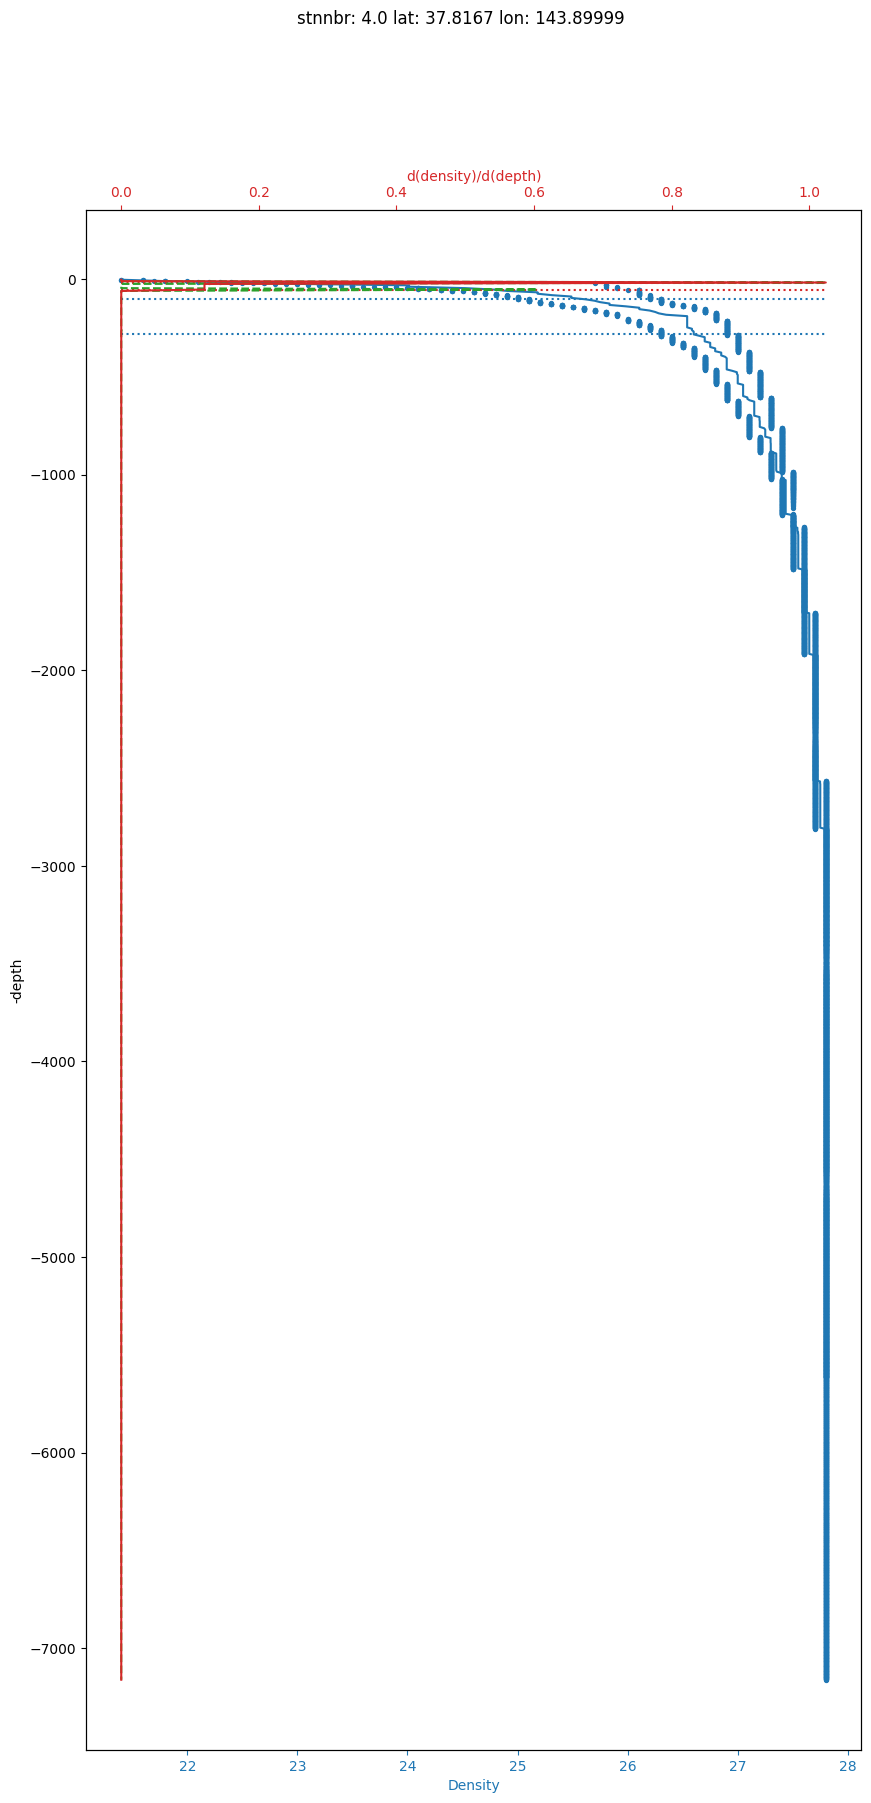

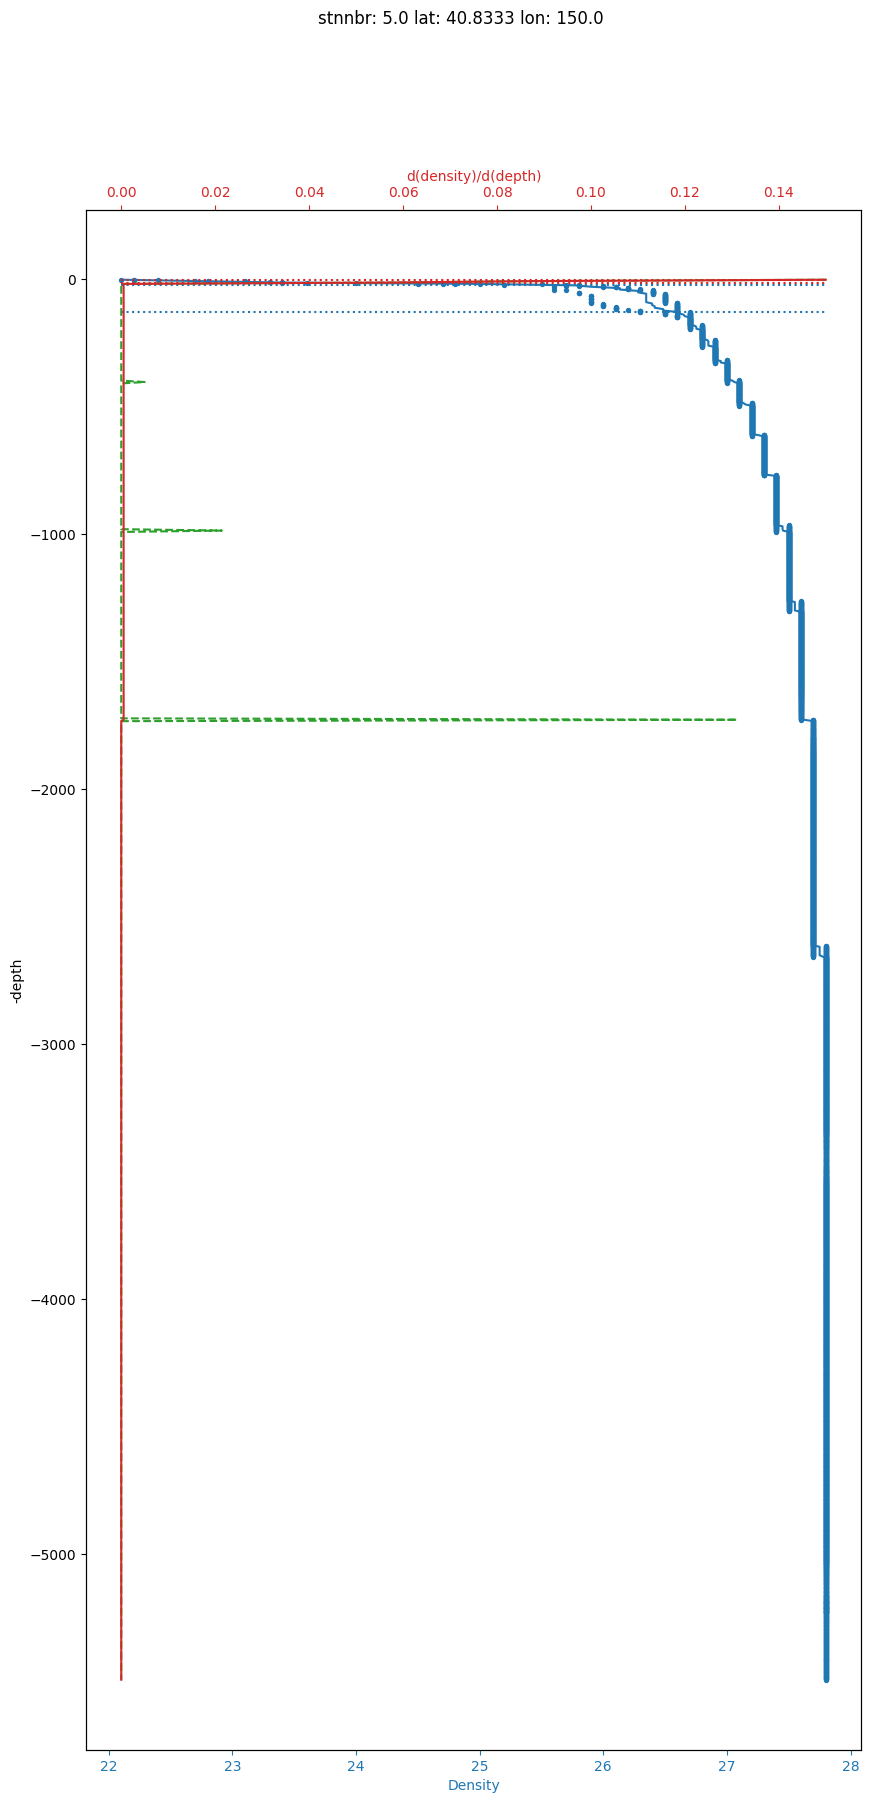

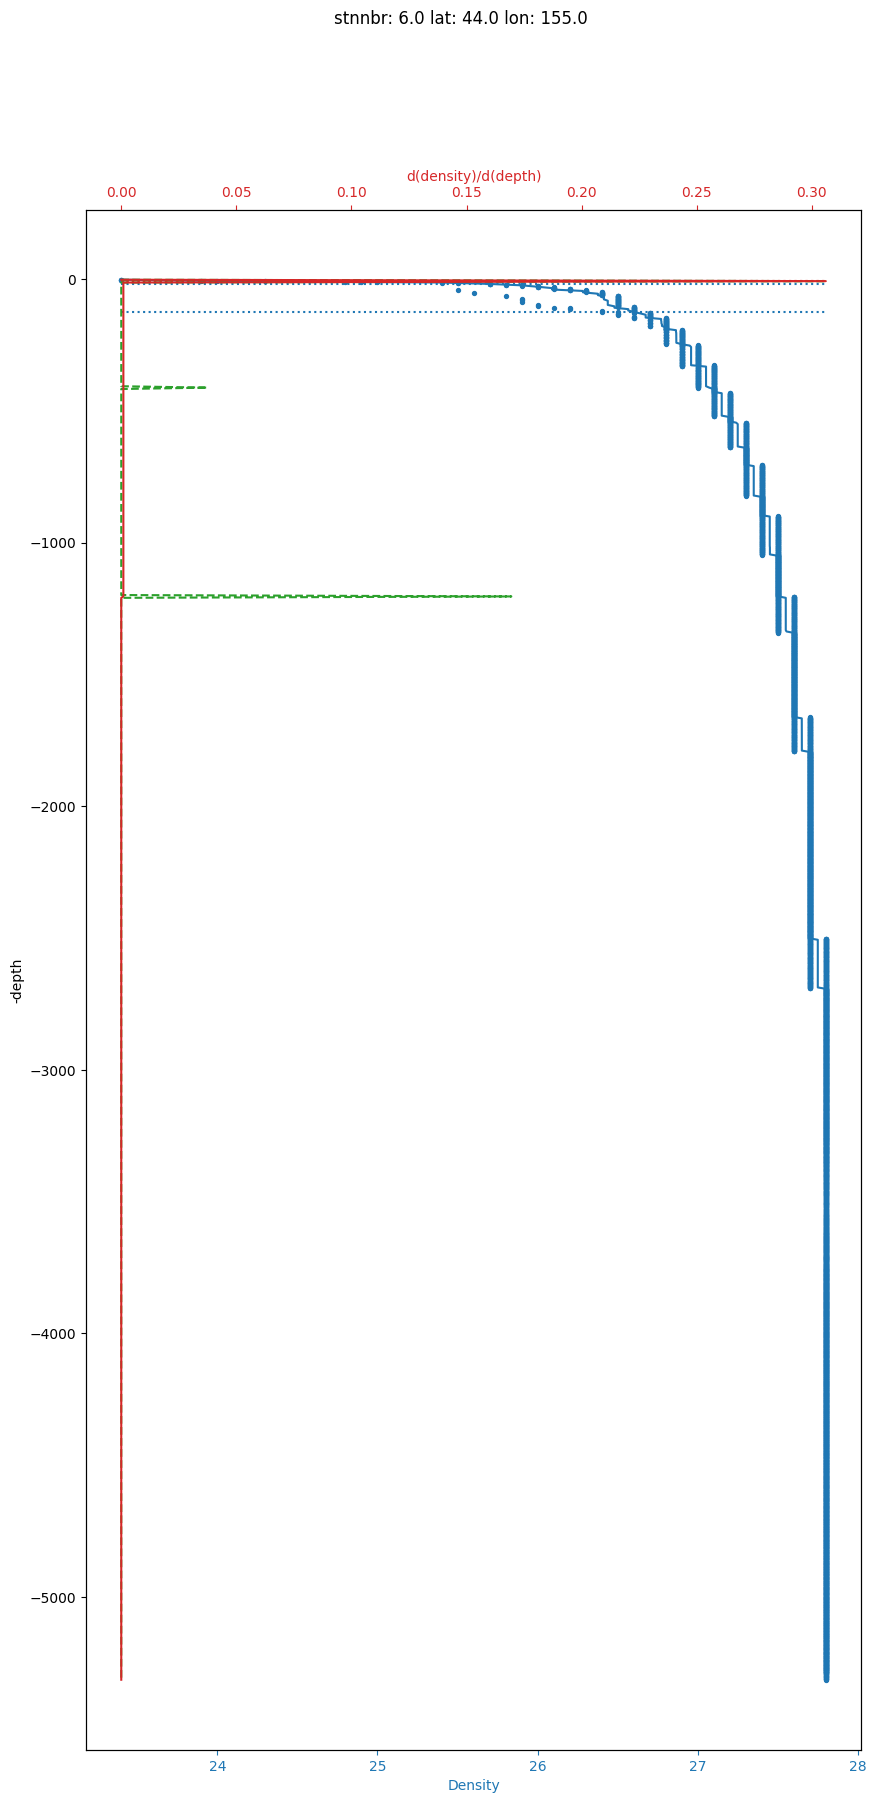

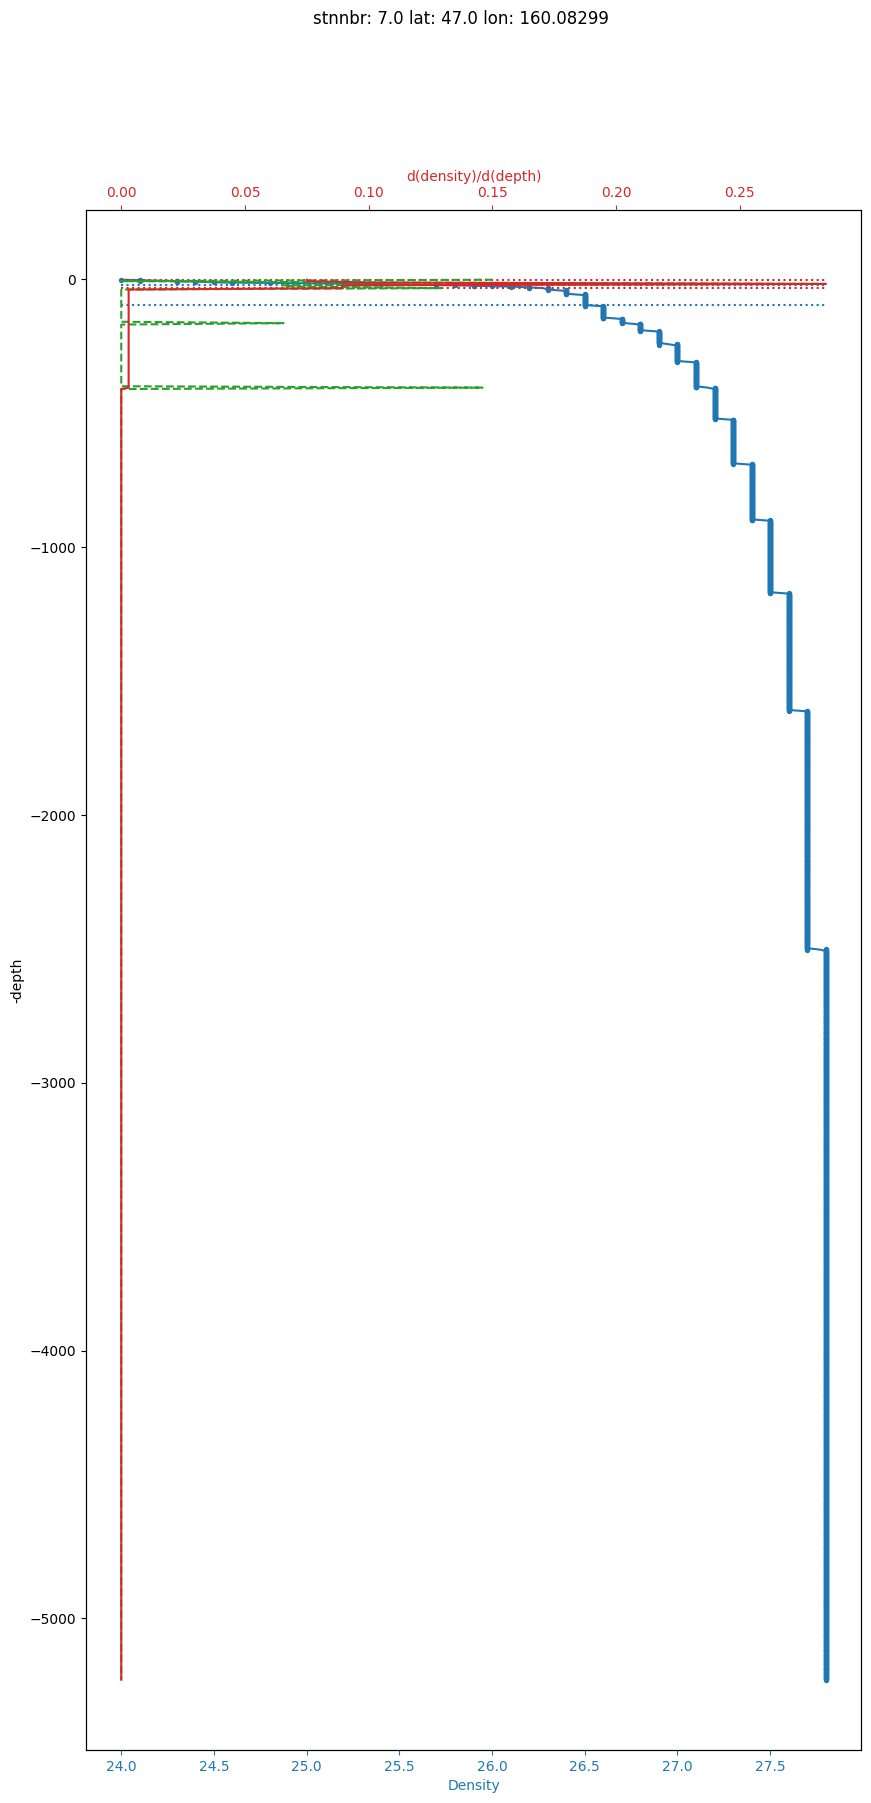

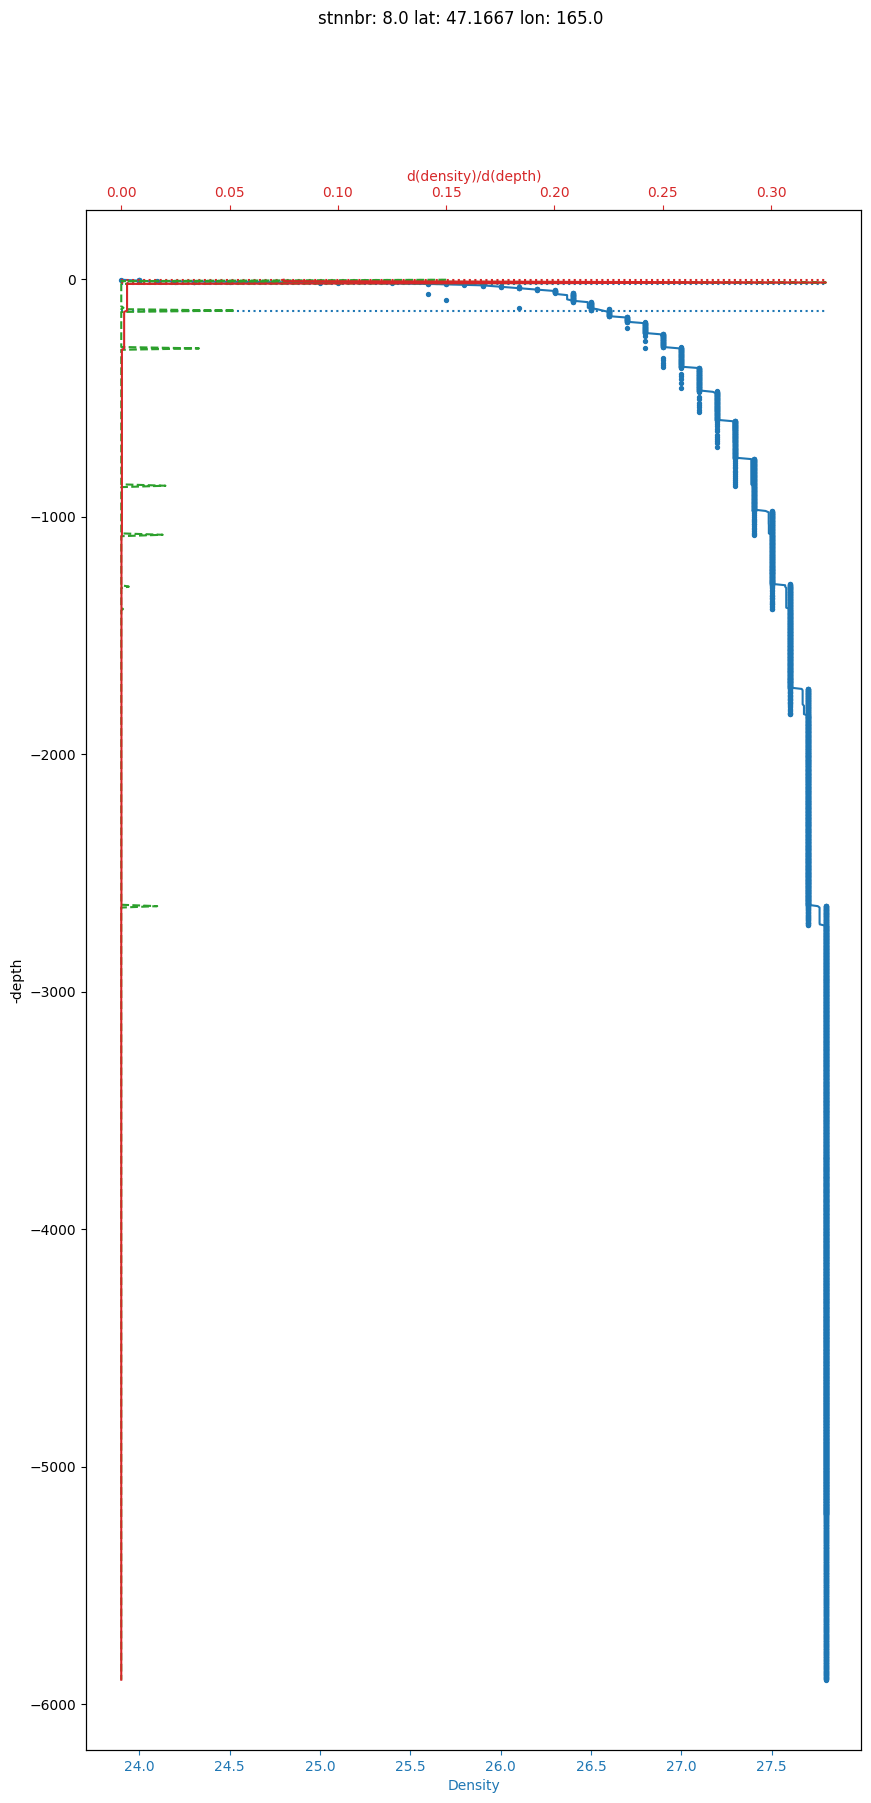

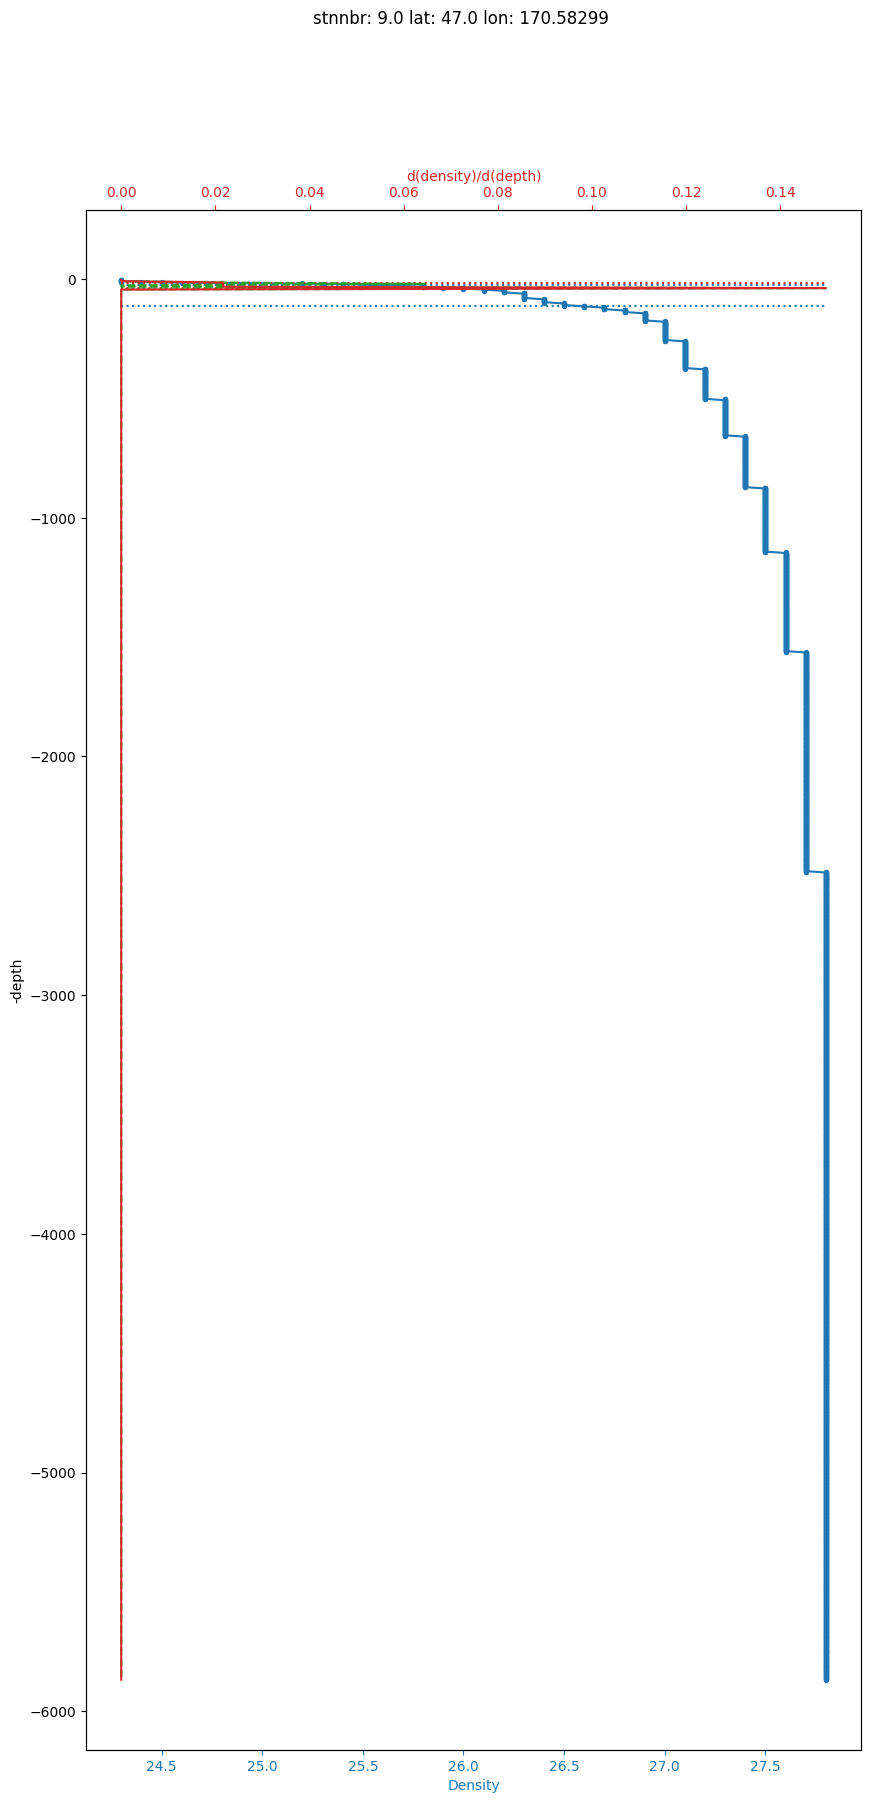

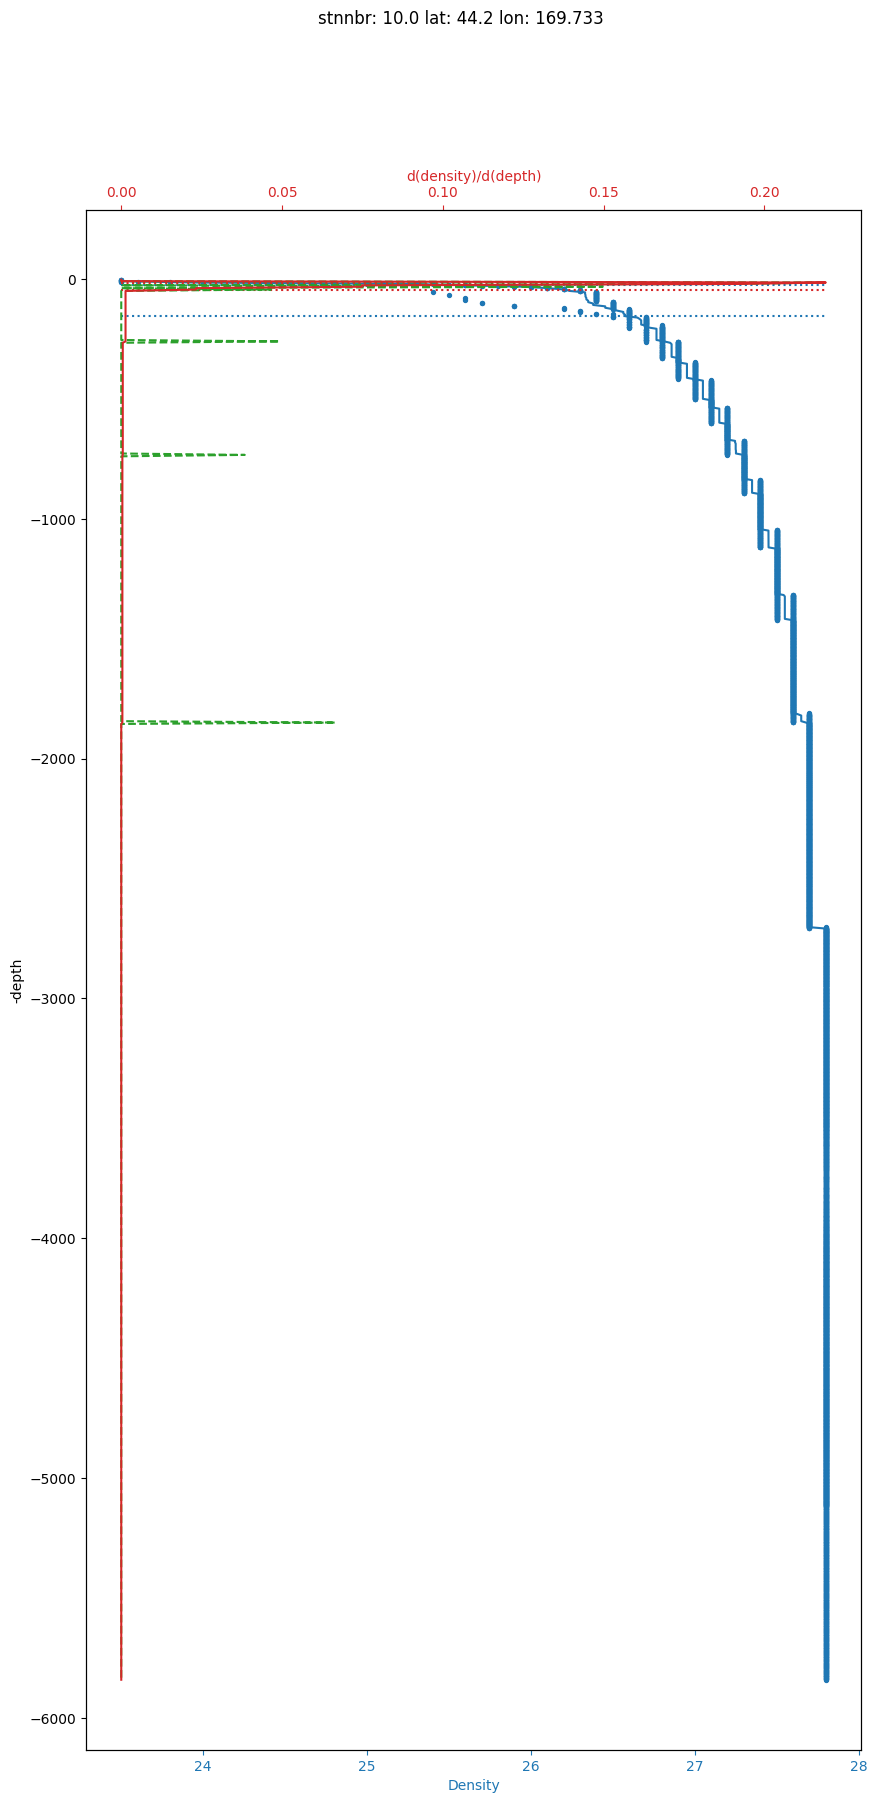

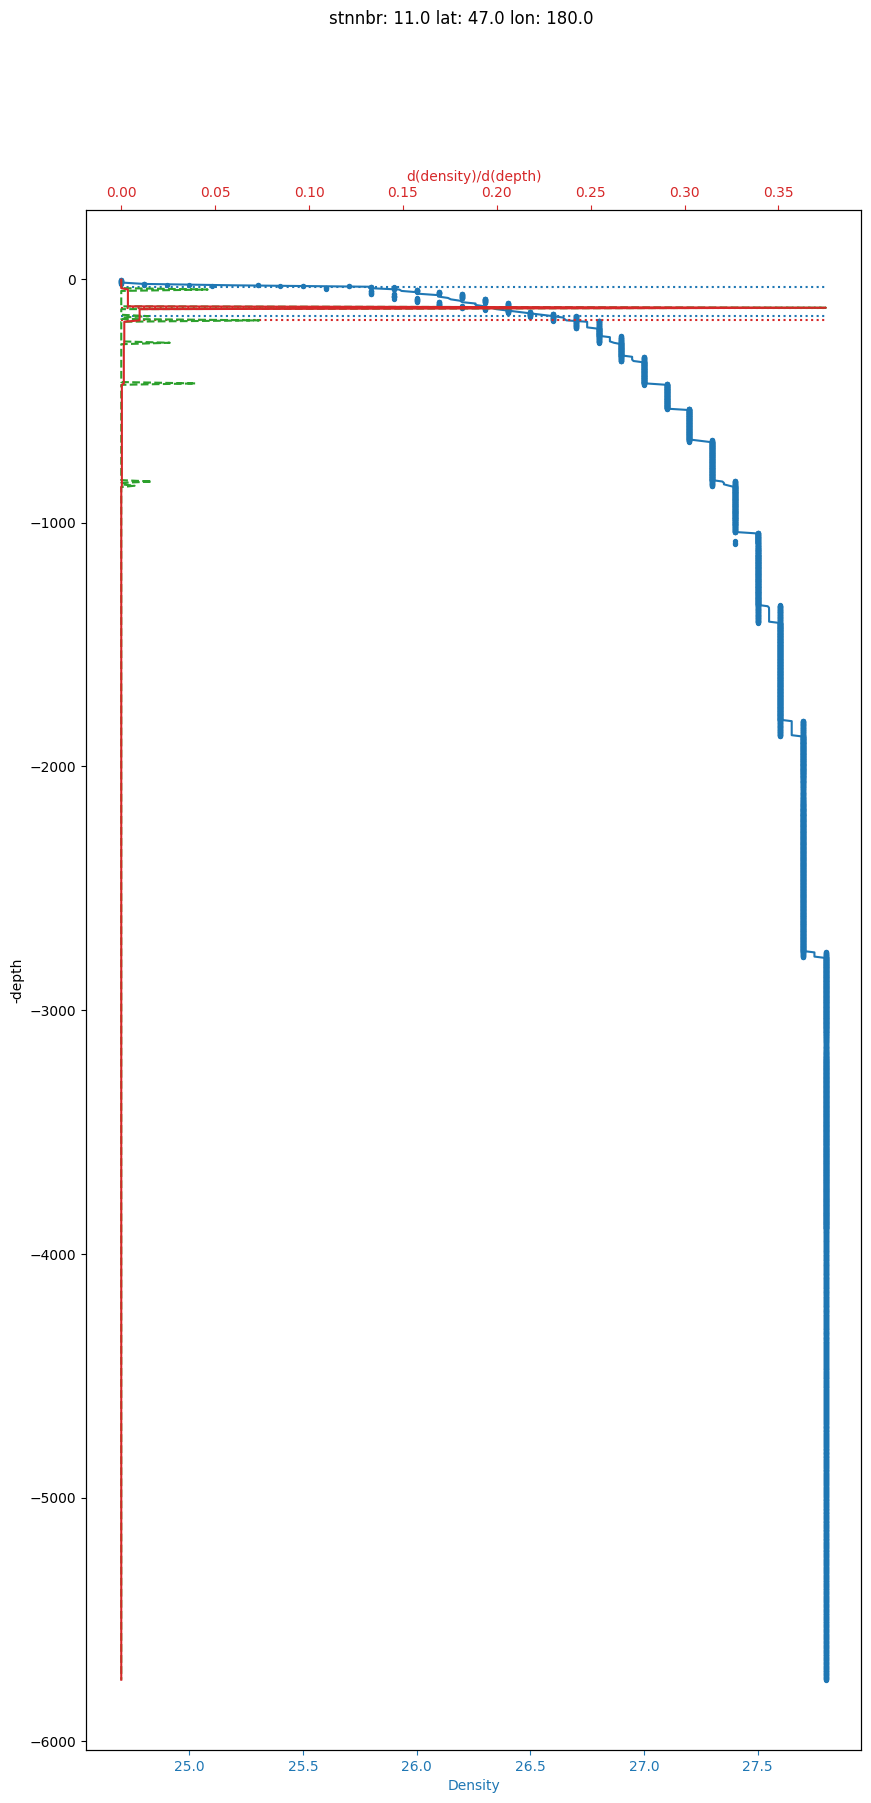

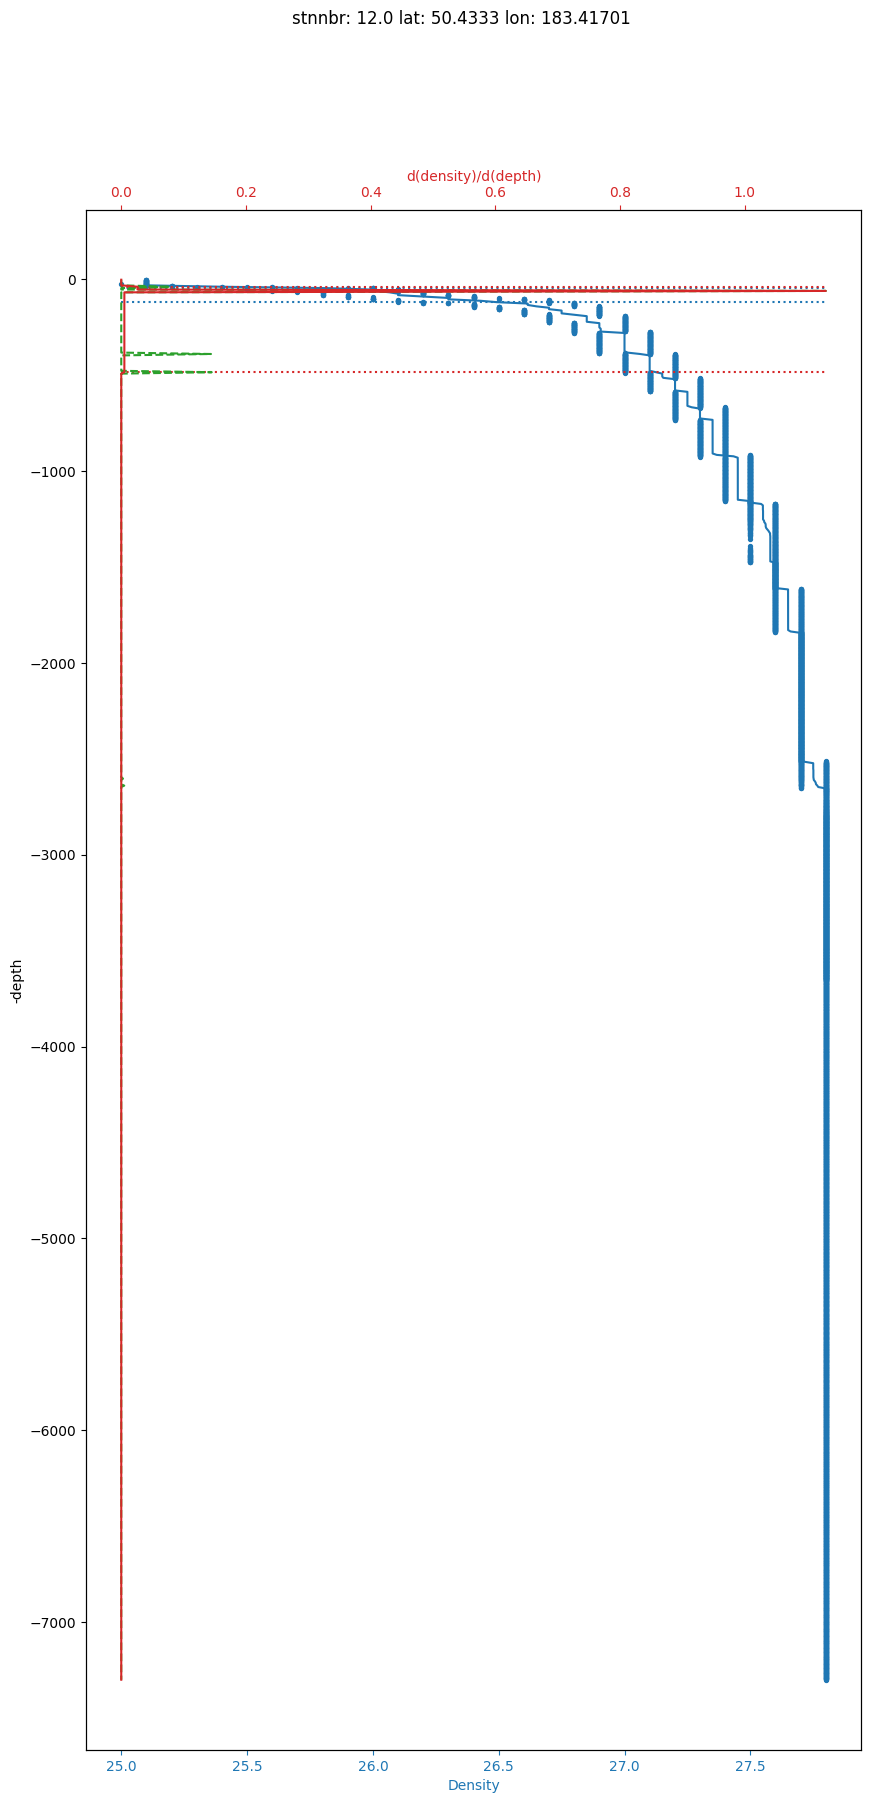

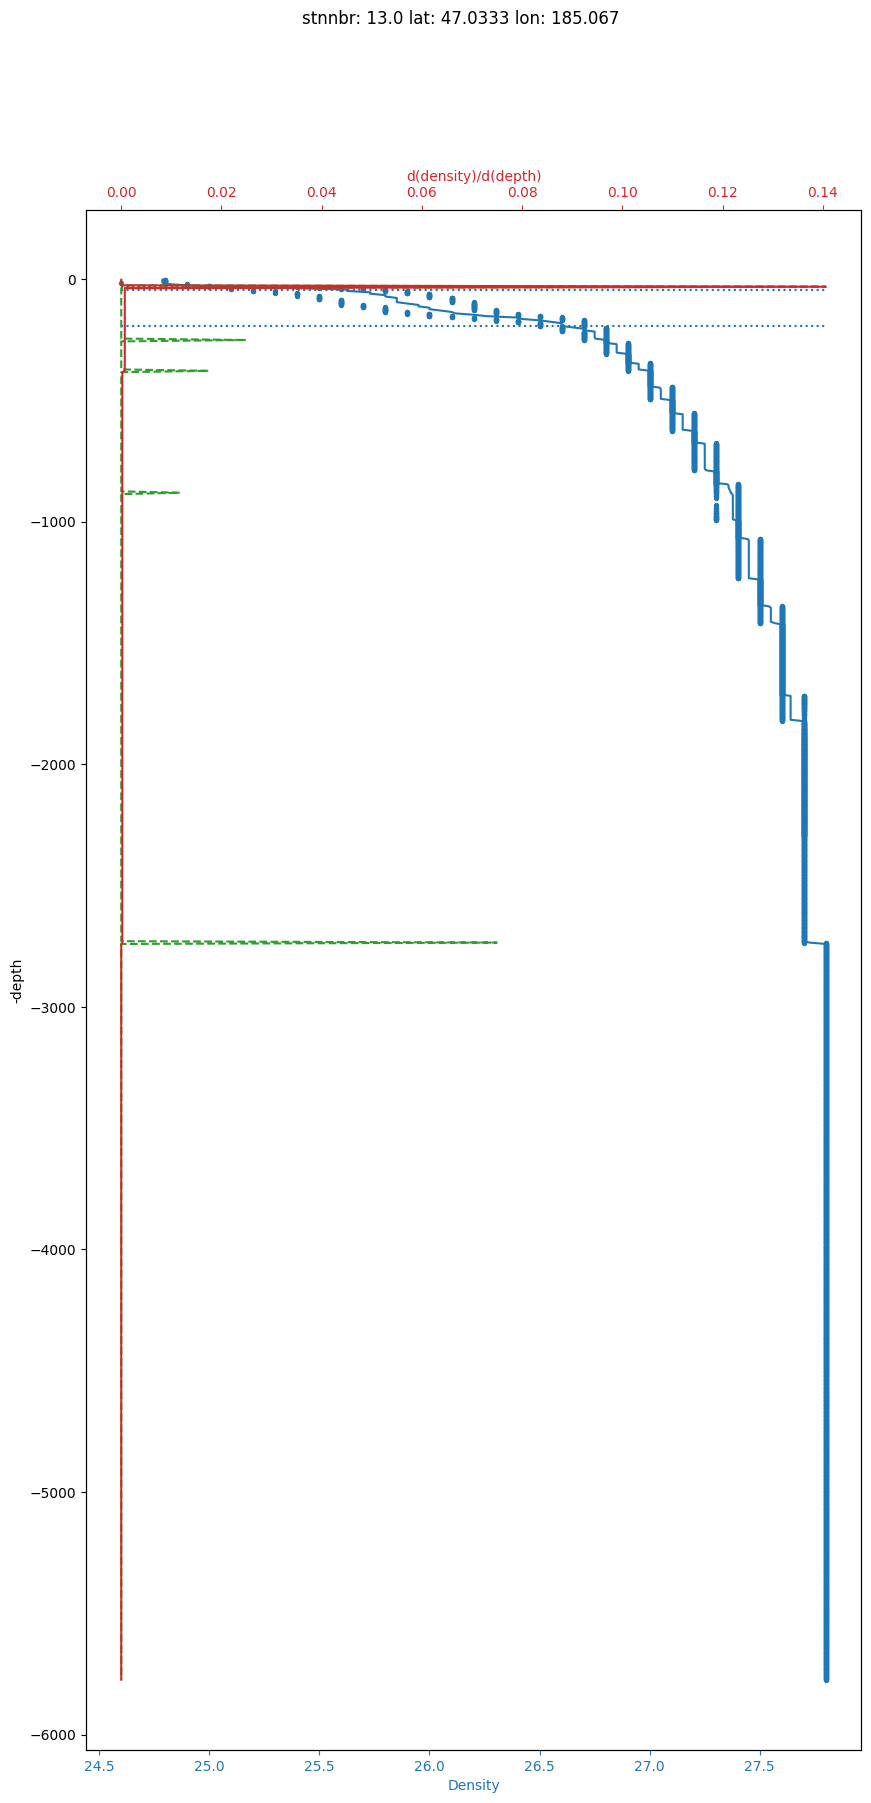

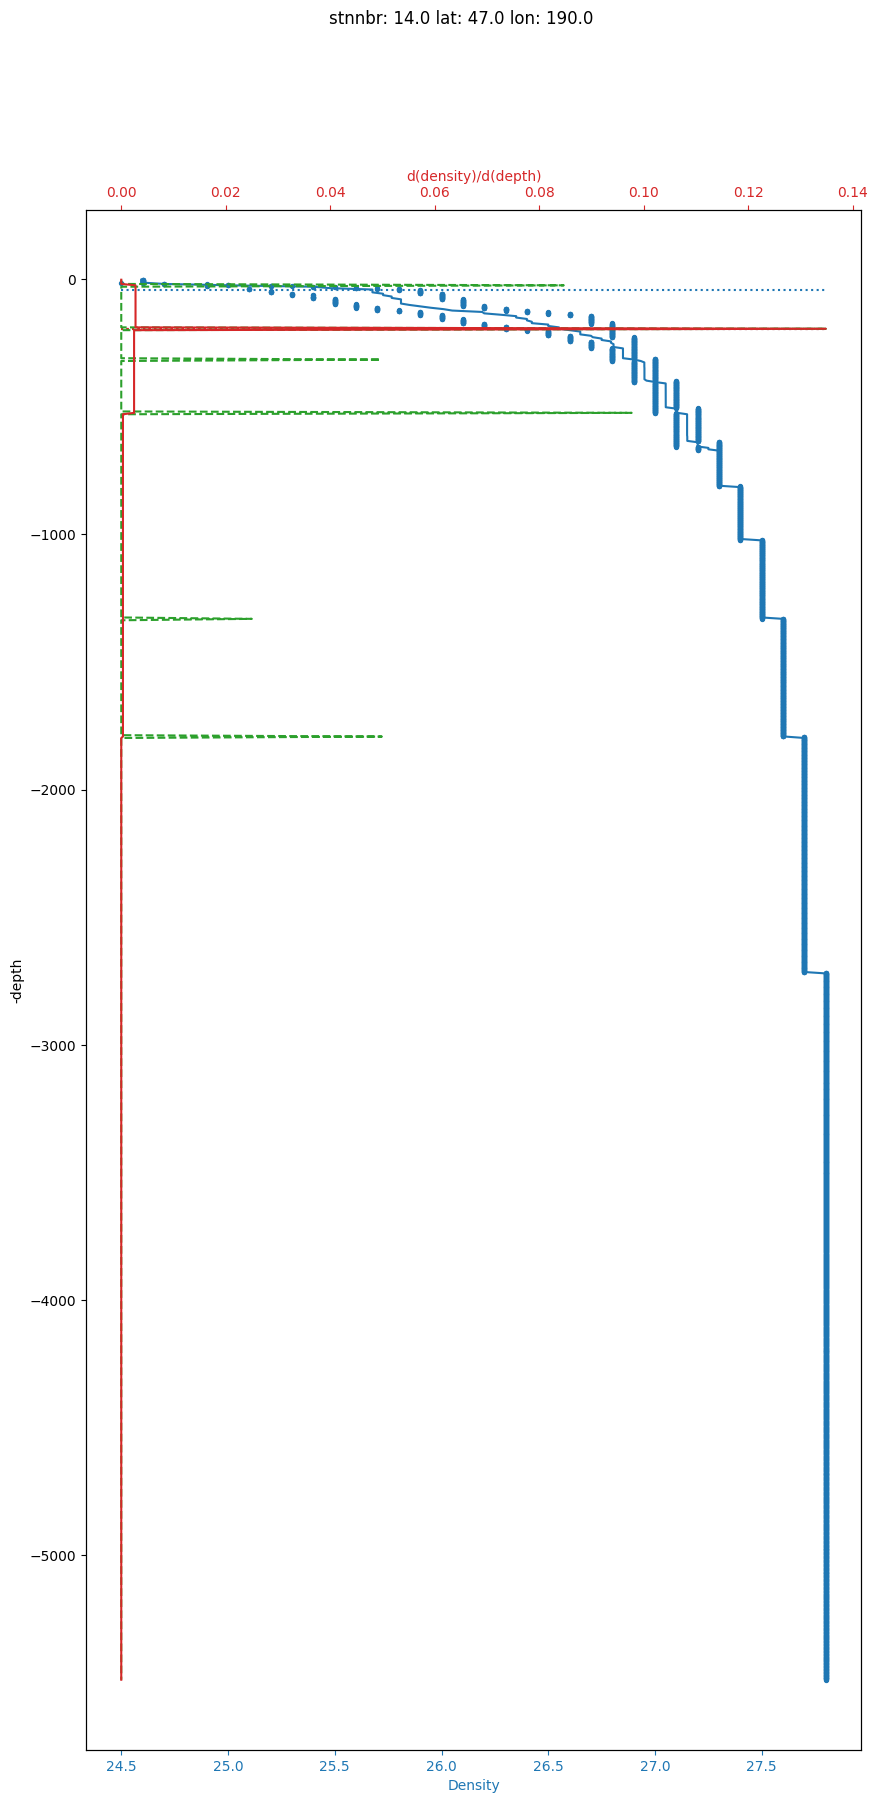

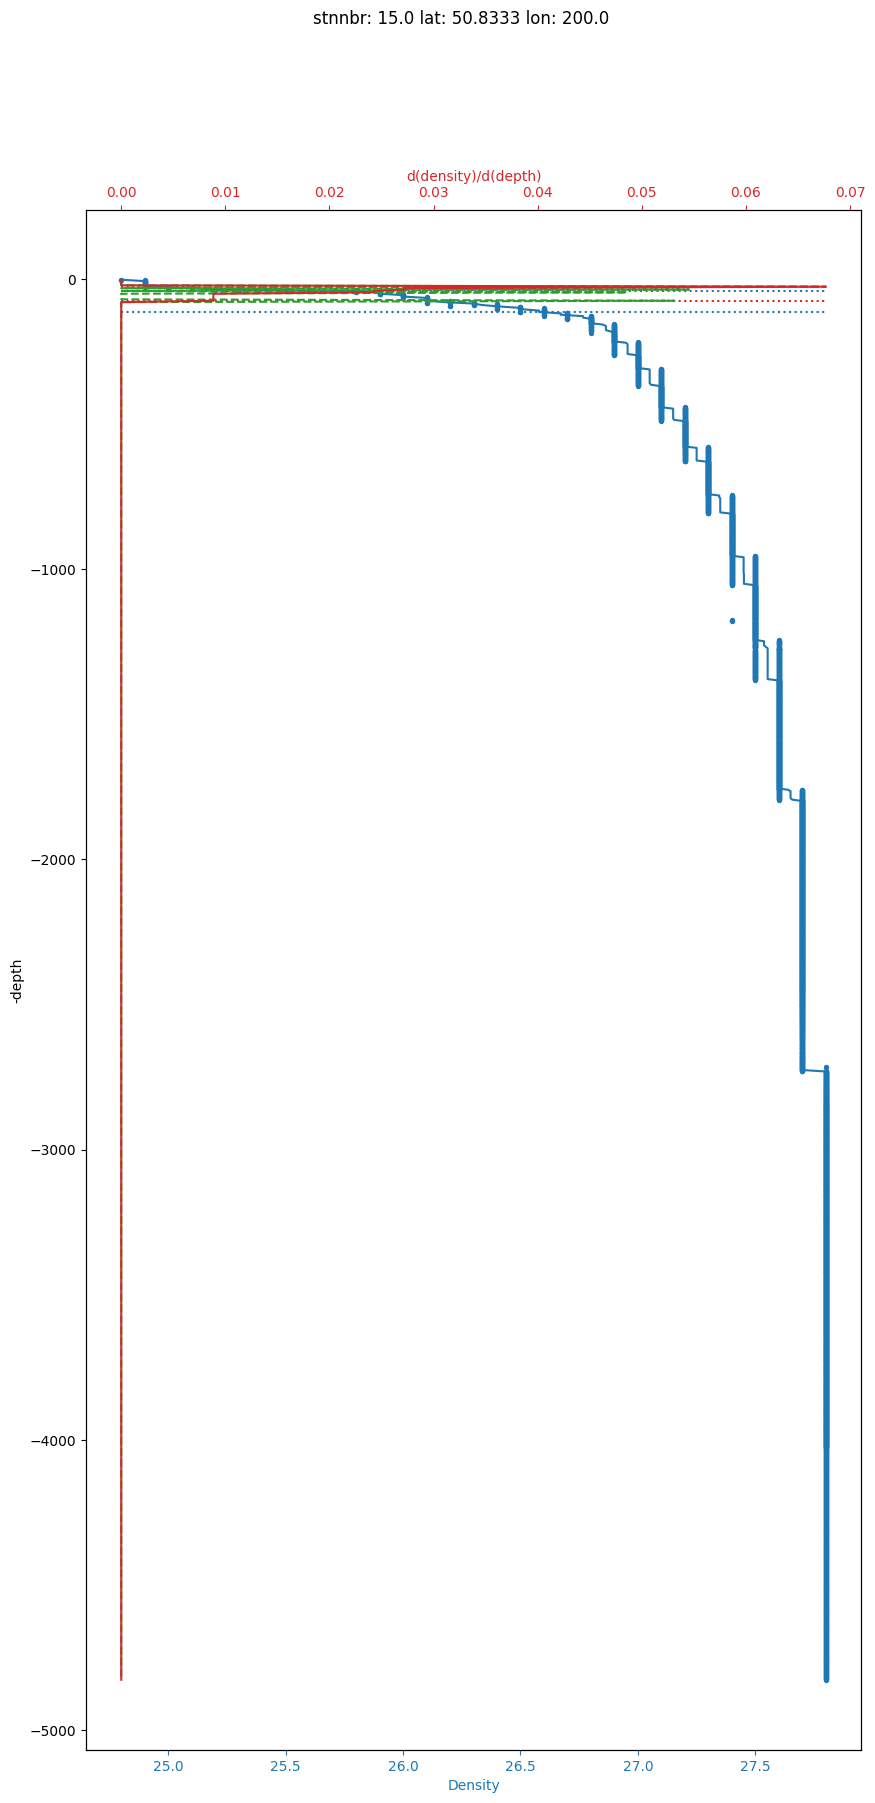

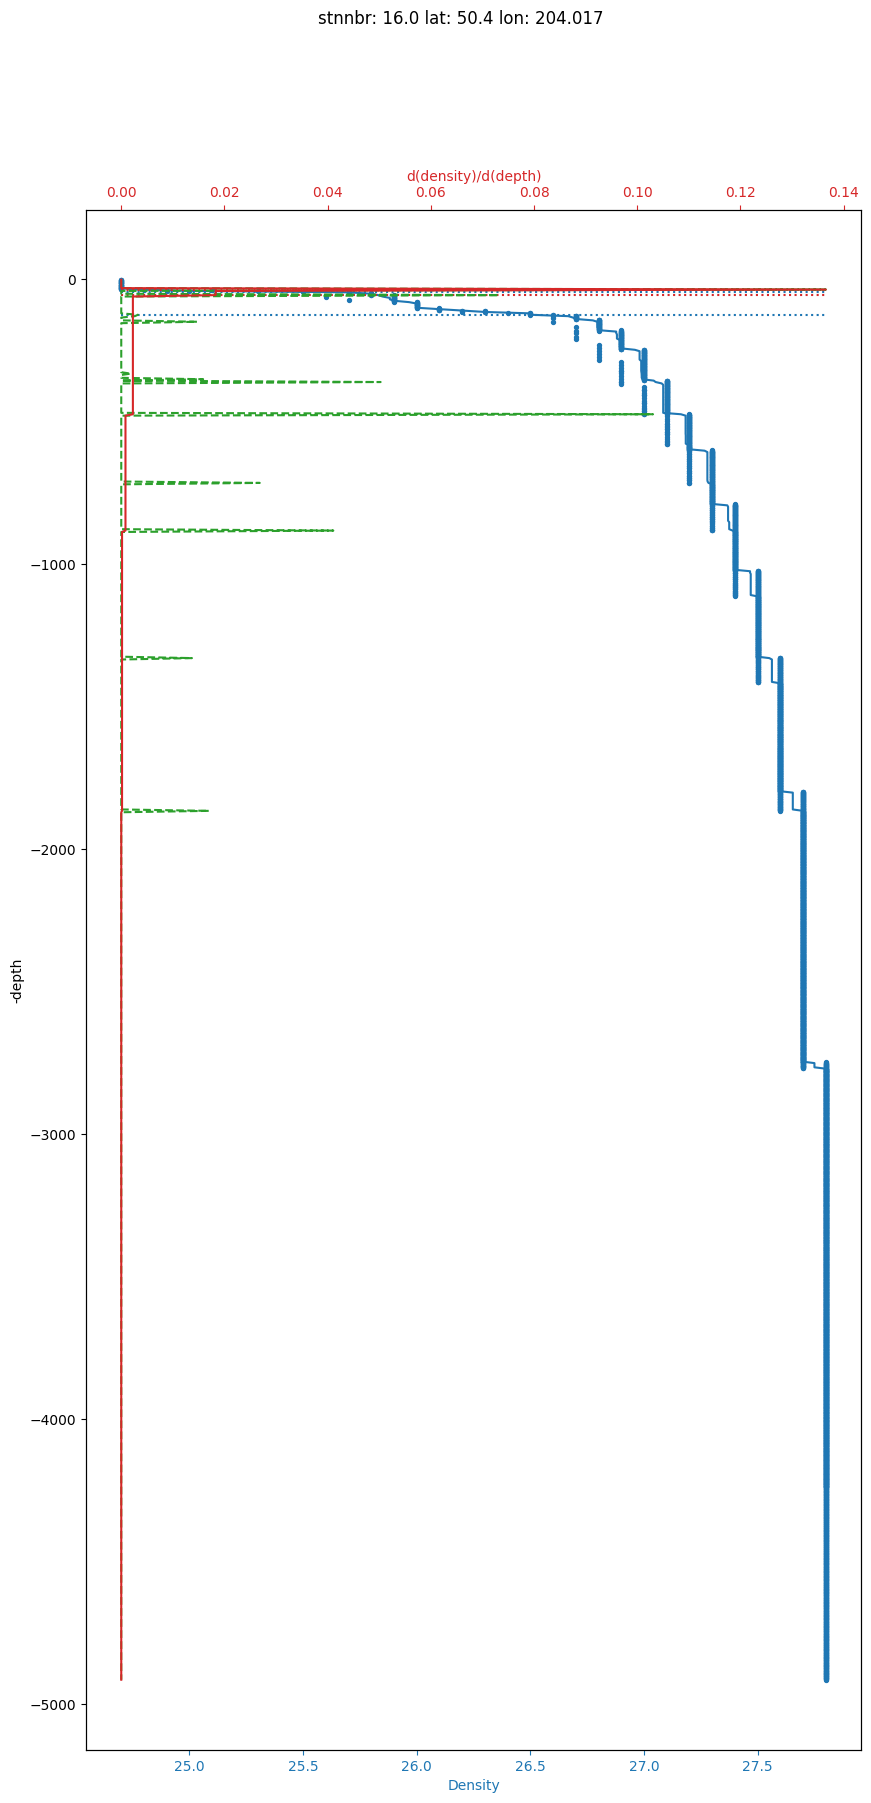

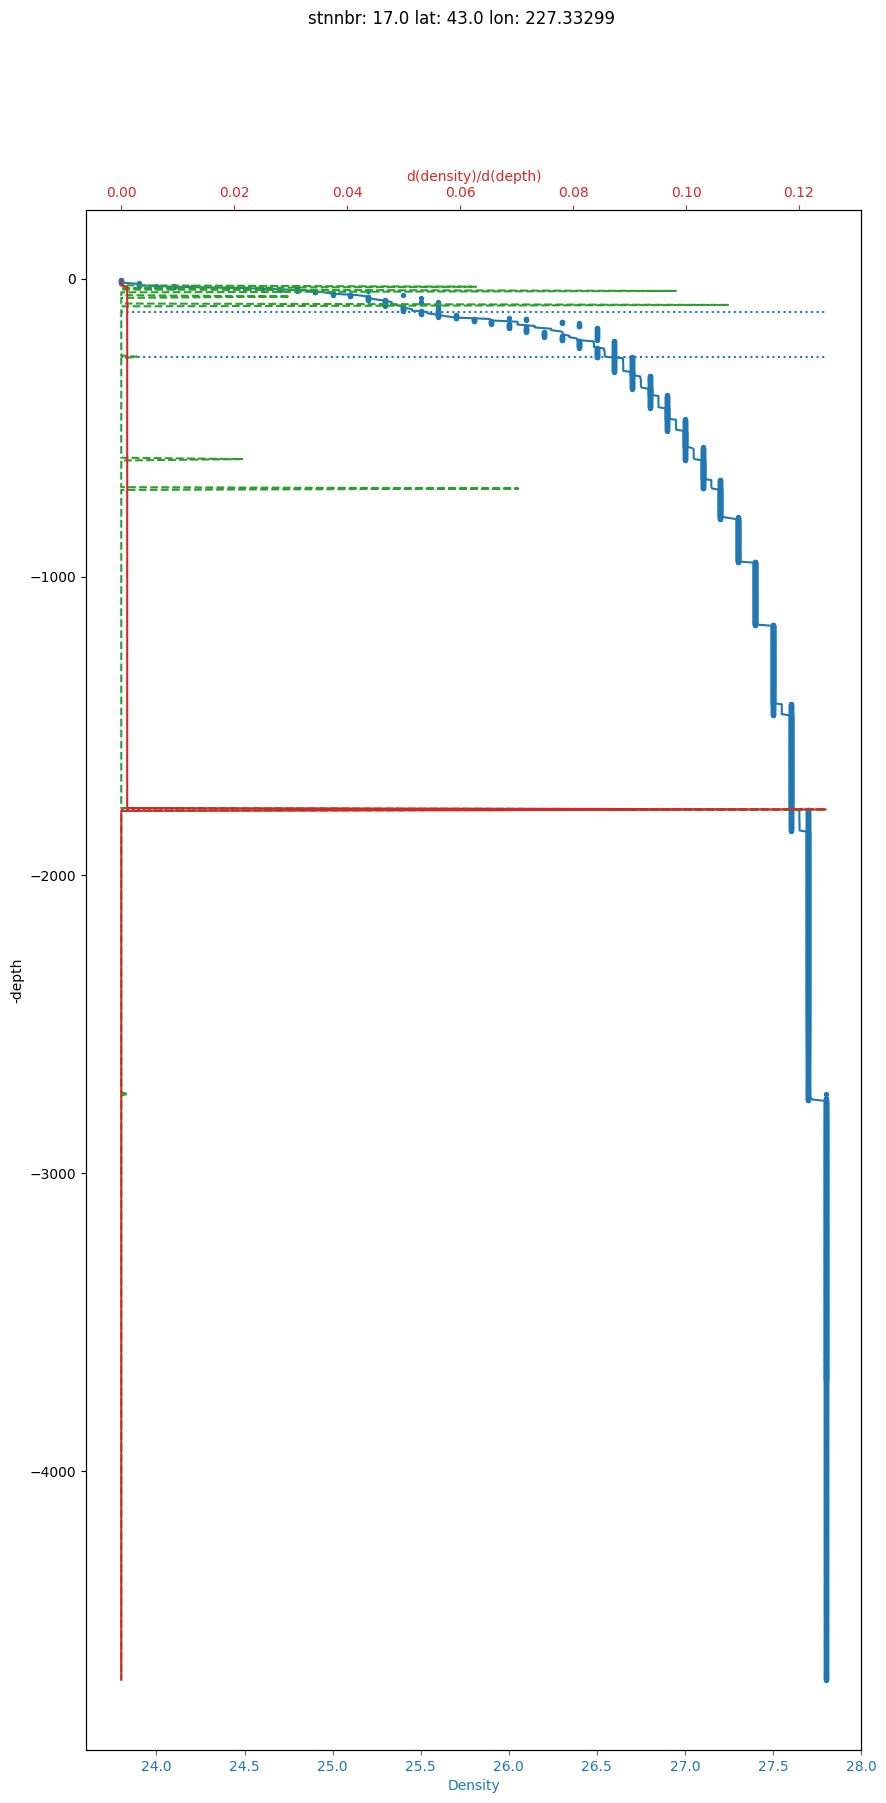

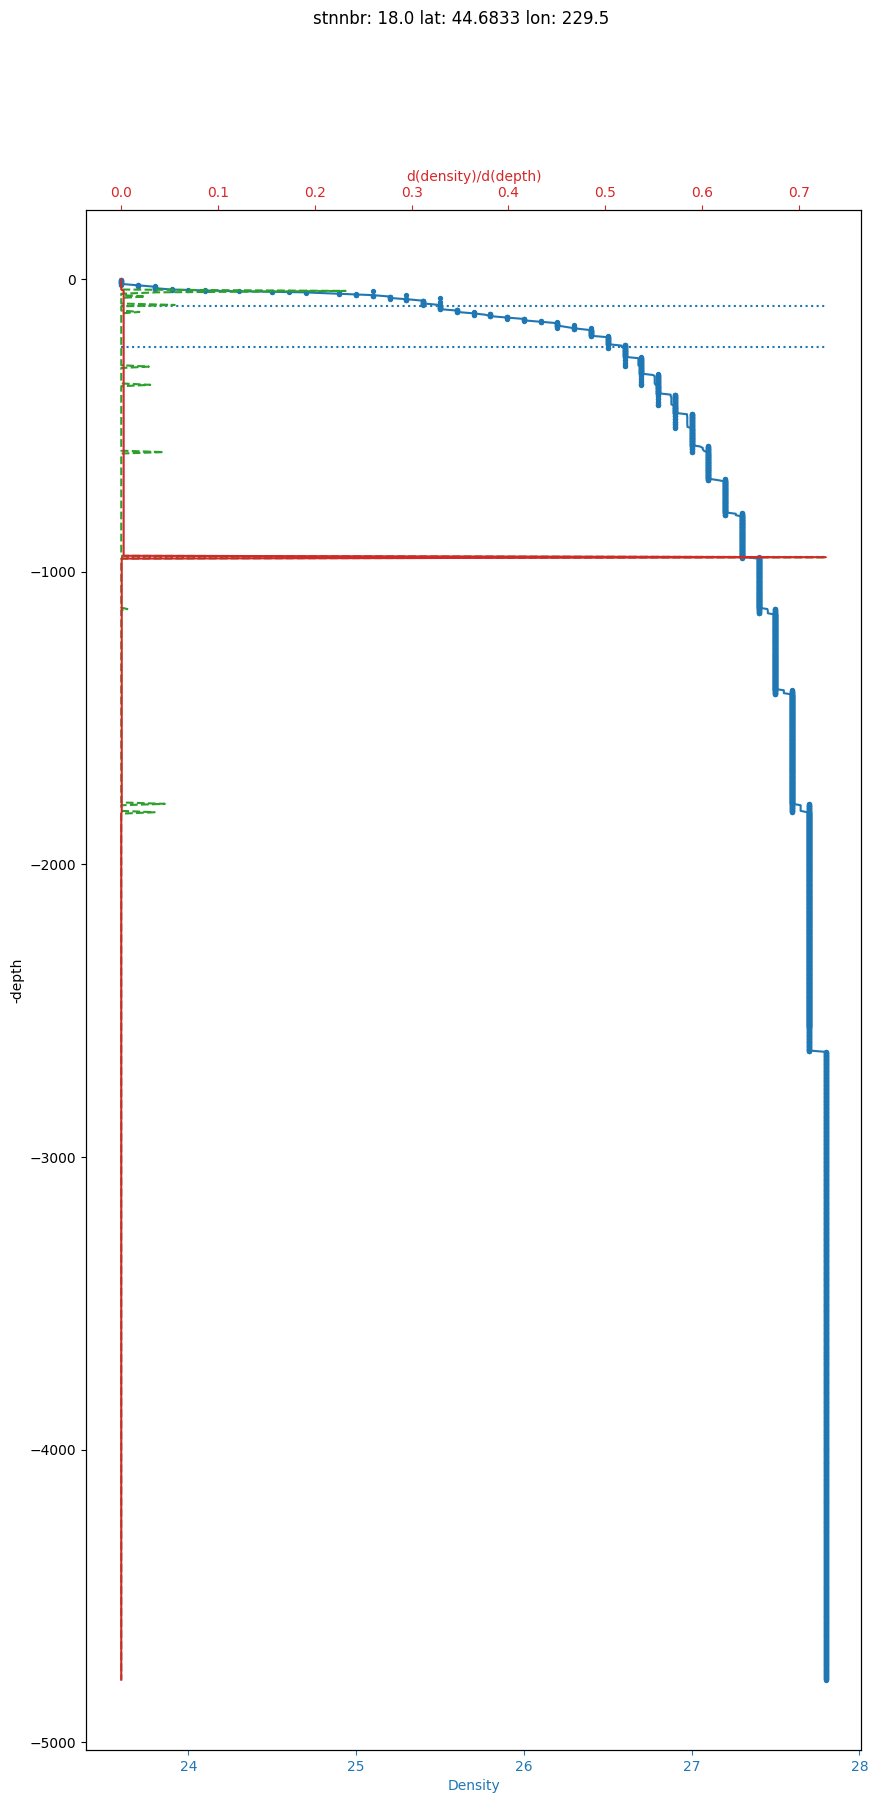

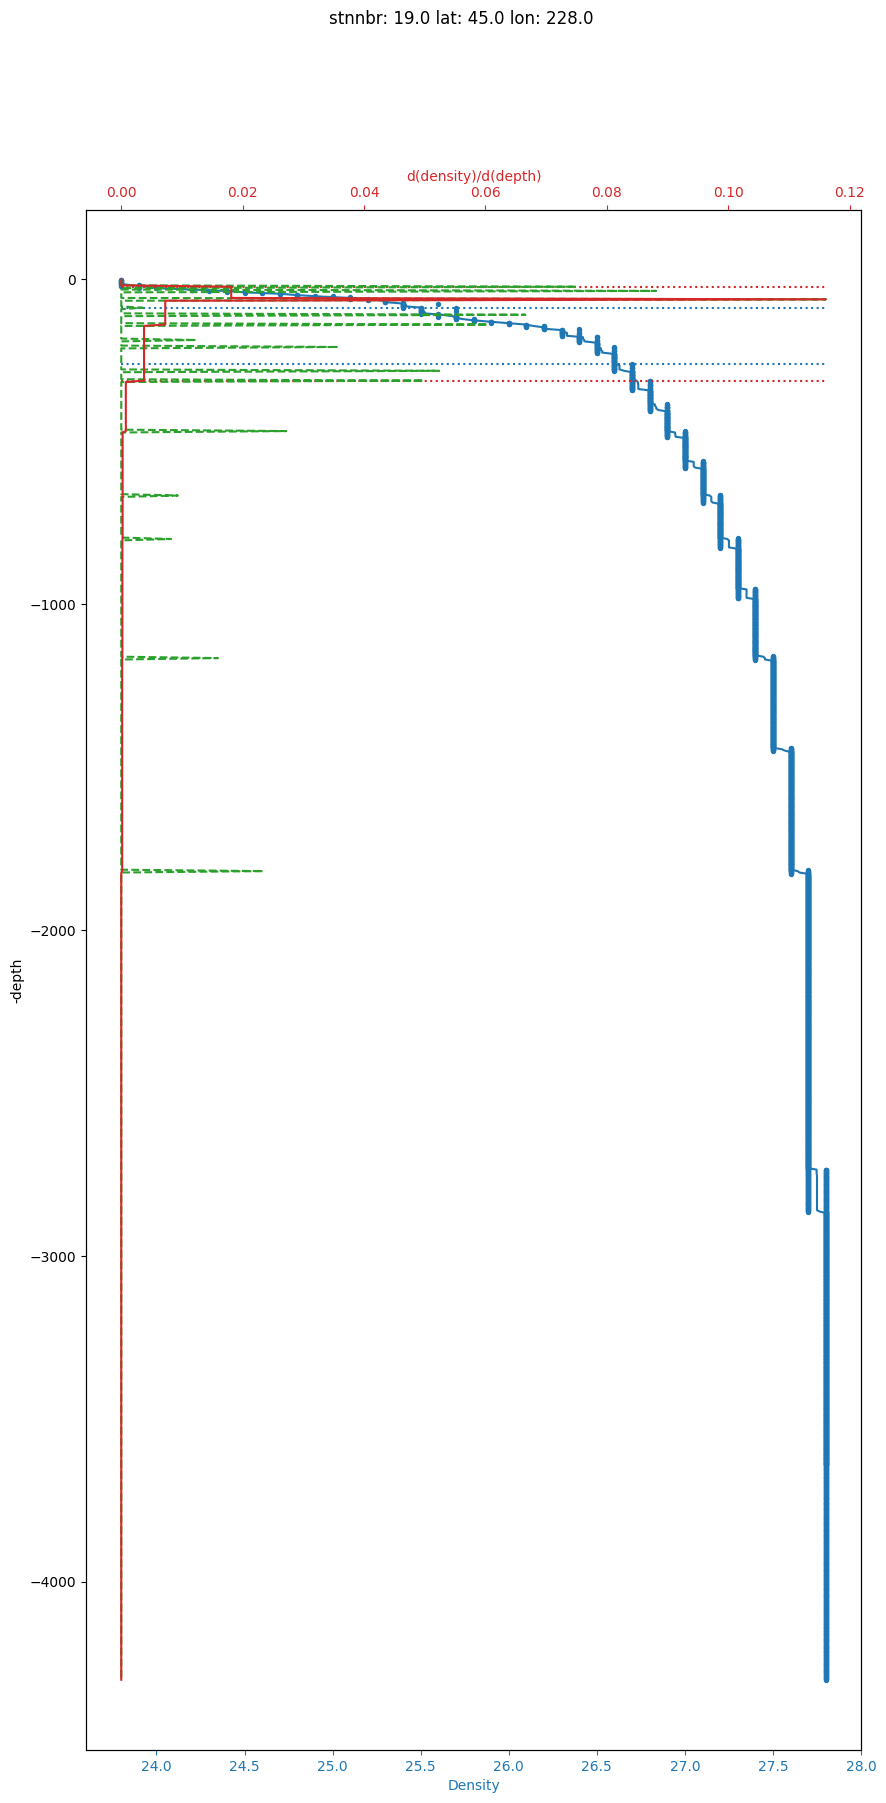

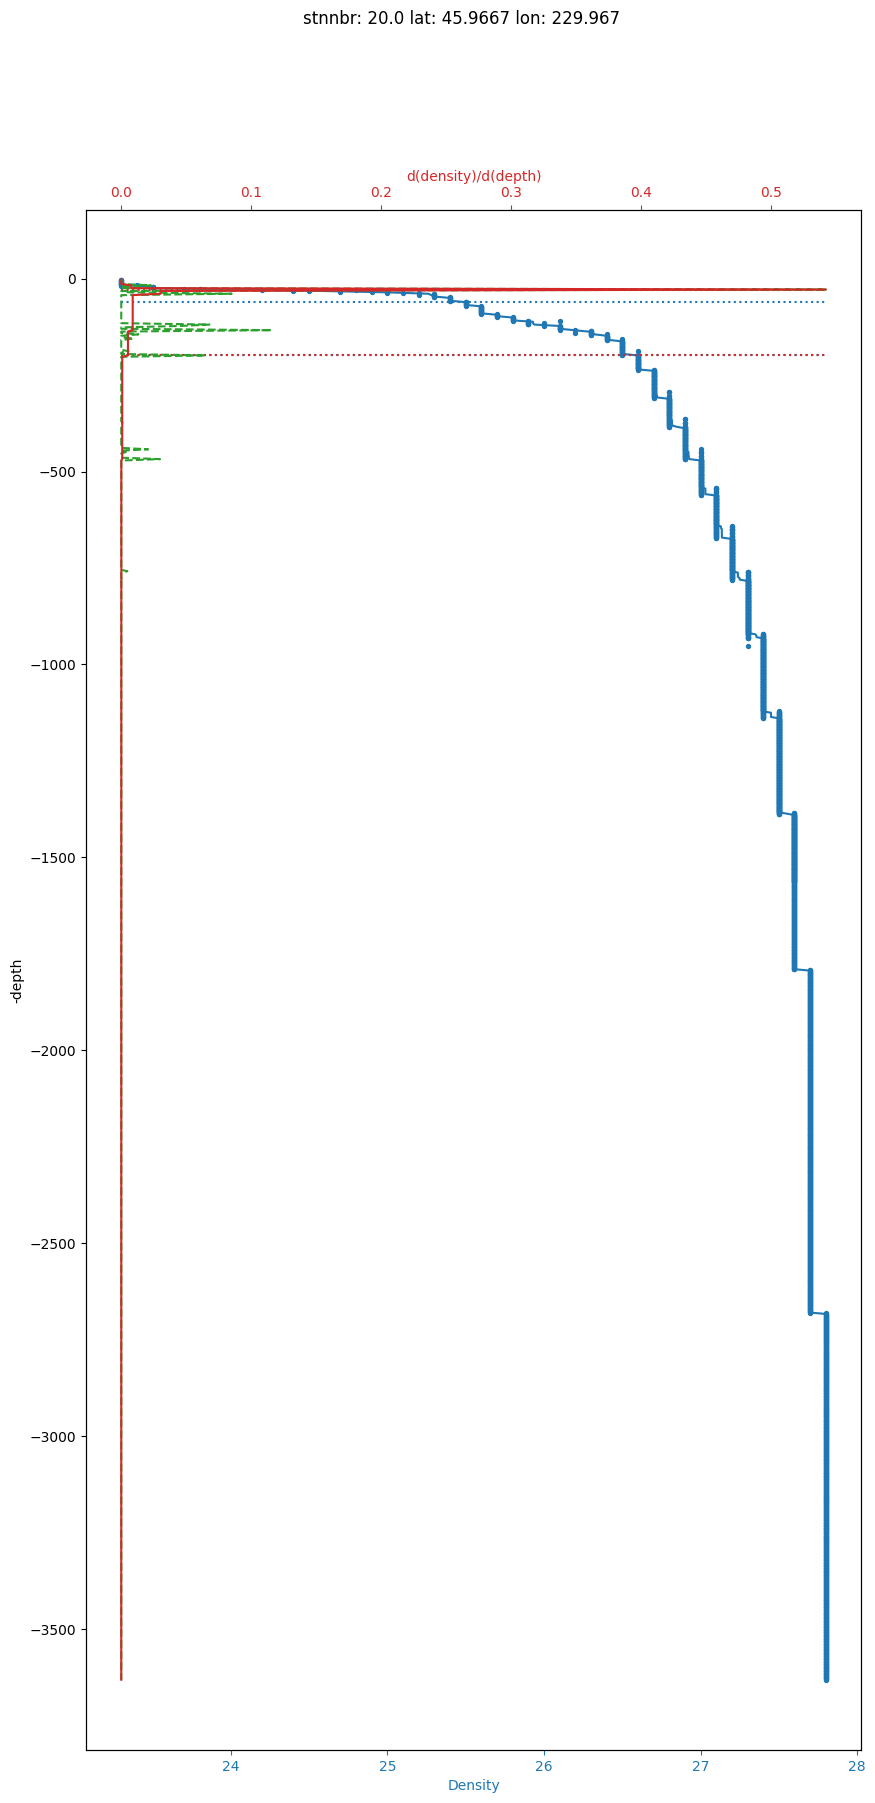

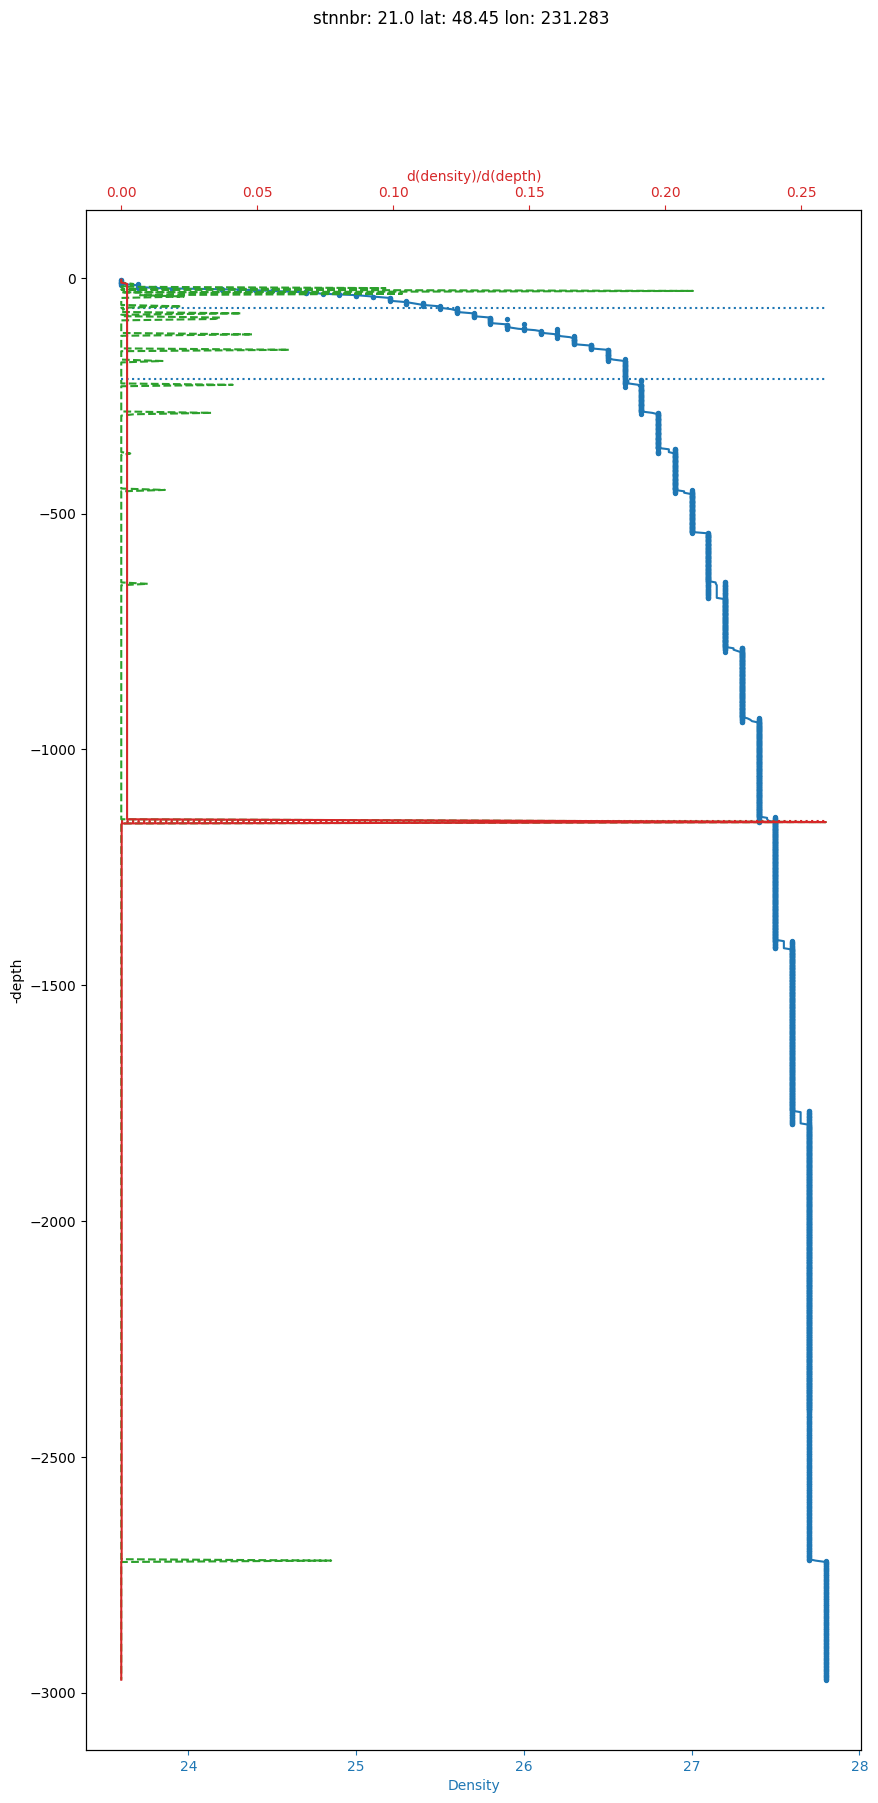

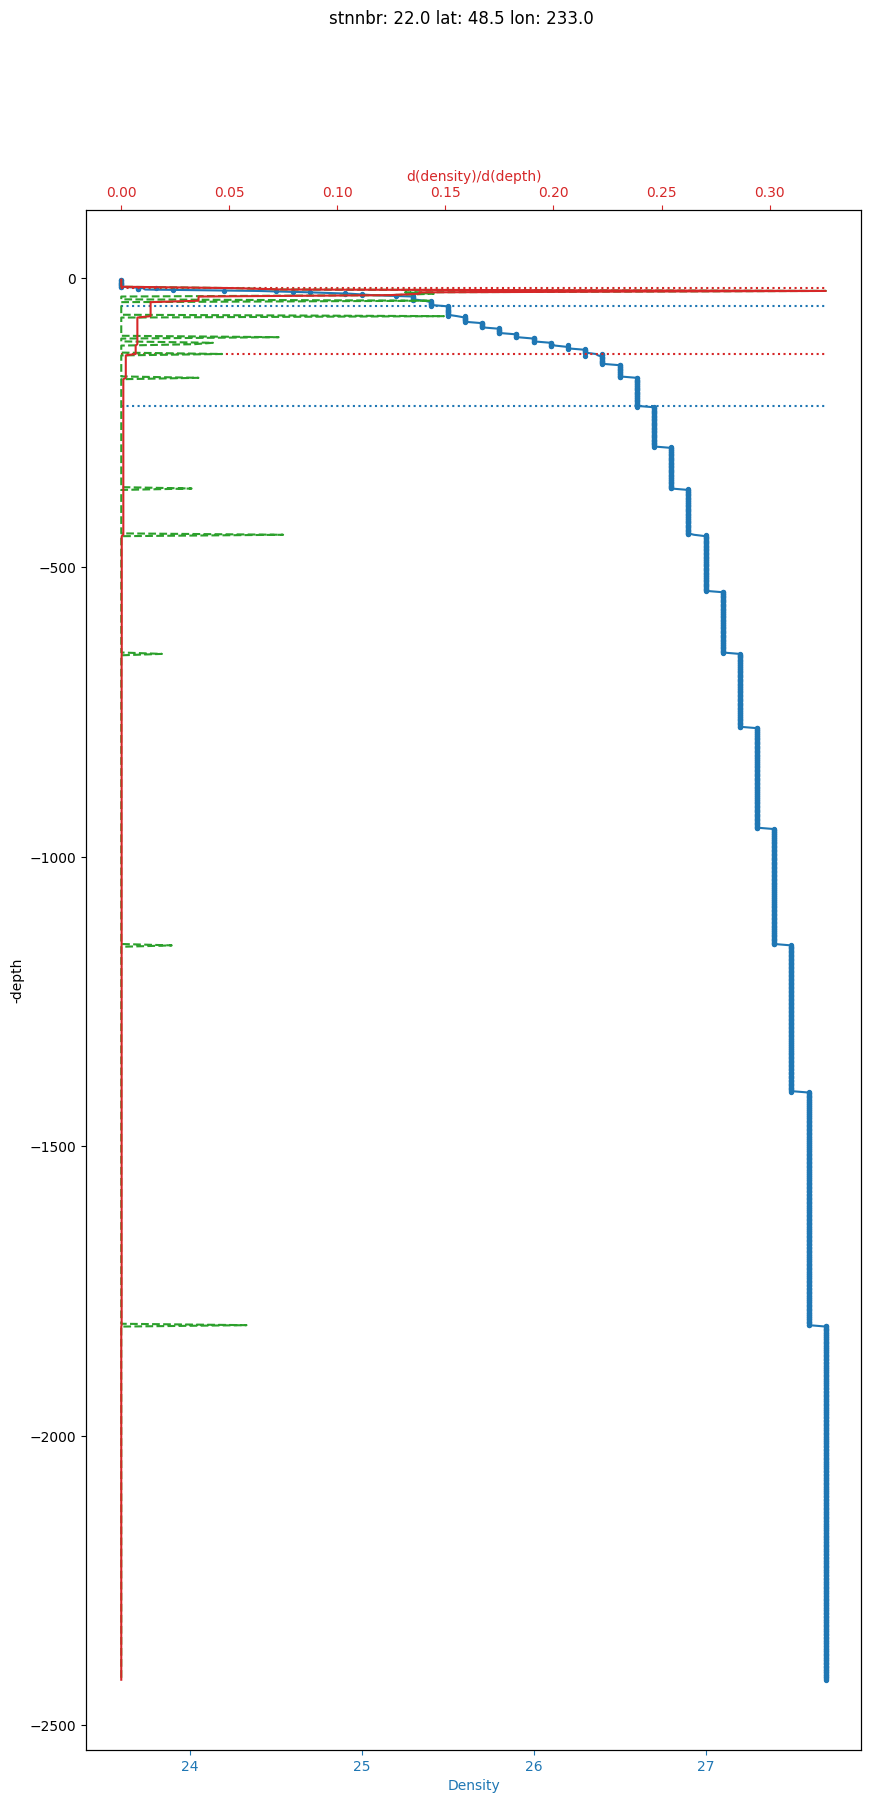

In [22]:
import scipy.interpolate
import scipy.signal
import sklearn.isotonic
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict

TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5

station_to_tcstartend = OrderedDict()

toplot_dataset = {"lat":[], "lon":[], "depth":[], "sig0":[]}

#let's plot the profiles per-station
#stations = np.unique(GP02_df['STNNBR'])
#for stn in sorted(stations):
    #stn_data = GP02_df[GP02_df['STNNBR']==stn]
#RESTRICT data above to data with station number equal to station

for stn in sorted(stn_to_data.keys()):
    stn_data = stn_to_data[stn]

    #fit a spline to it
    density = np.array(stn_data.sig0)
    depth = np.array(stn_data.depth)

    argsort_depth = np.argsort(depth)
    sorted_depth = depth[argsort_depth]
    sorted_density = density[argsort_depth]

    #'correct' the density to enforce monotonic increase with depth
    sorted_monotonic_density = (sklearn.isotonic.IsotonicRegression()
       .fit_transform(X=sorted_depth, y=sorted_density))

    fig, ax1 = plt.subplots(figsize=(10,20))
    fig.suptitle("stnnbr: "+str(stn)
                 #+" cast: "+str(stn_data.cast)
                 +" lat: "+str(stn_data.lat)
                 +" lon: "+str(stn_data.lon))
    ax1.set_ylabel("-depth")

    ax1.scatter(sorted_density, -sorted_depth, s=8, color='C0')

    ##Smooth the density with a savgol filter
    #sorted_smooth_density = scipy.signal.savgol_filter(sorted_density, 5, 2)
    #ax1.plot(sorted_smooth_density, -sorted_depth, color='C1')

    pchip_spl = scipy.interpolate.PchipInterpolator(
                 sorted_depth, sorted_monotonic_density)
    interp_depths = np.linspace(min(depth), max(depth), 1000)
    interp_density = pchip_spl(interp_depths)

    toplot_dataset["lat"].extend([stn_data.lat for x in interp_density])
    toplot_dataset["lon"].extend([stn_data.lon for x in interp_density])
    toplot_dataset["sig0"].extend(interp_density)
    toplot_dataset["depth"].extend(interp_depths)

    ax1.plot(interp_density, -interp_depths, color="C0")
    ax1.set_xlabel("Density")

    #Plot the flat density-based thresholds
    density_cutoff_tc_depths = (
        interp_depths[(interp_density <= TC_UPPER_BOUND)*
                      (interp_density >= TC_LOWER_BOUND)])
    density_cutoff_tc_start_depth = (np.min(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    density_cutoff_tc_end_depth = (np.max(density_cutoff_tc_depths) if
      len(density_cutoff_tc_depths) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_start_depth, -density_cutoff_tc_start_depth],
             color="C0", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-density_cutoff_tc_end_depth, -density_cutoff_tc_end_depth],
             color="C0", linestyle=":")
    #ax1.plot(akima_spl(interp_depths), -interp_depths)

    ax1.tick_params(axis='x', colors='C0')
    ax1.xaxis.label.set_color('C0')
    ax2 = ax1.twiny()
    ax2.tick_params(axis='x', colors='C3')
    ax2.xaxis.label.set_color('C3')

    first_derivatives = pchip_spl.derivative(1)(interp_depths)

    ax2.plot(first_derivatives, -interp_depths, color="C2", linestyle="--")

    ax2.set_xlabel("d(density)/d(depth)")

    #Procedure: find the maximum of the first derivative, then fit isotonic
    # regression to enforce monotonic increasing and monotic decreasing to
    # get a better estimate of the derivatives.

    max_first_d_depth = np.argmax(first_derivatives)+1
    if (max_first_d_depth > 1):
      increasing_first_d = sklearn.isotonic.IsotonicRegression().fit_transform(
            X=interp_depths[:max_first_d_depth],
            y=first_derivatives[:max_first_d_depth])
    else:
      increasing_first_d = [first_derivatives[0]]
    decreasing_first_d = -sklearn.isotonic.IsotonicRegression().fit_transform(
           X=interp_depths[max_first_d_depth:],
           y=-first_derivatives[max_first_d_depth:])

    corrected_first_d = np.array(list(increasing_first_d)
                                 +list(decreasing_first_d))
    ax2.plot(corrected_first_d, -interp_depths, color="C3")

    #threhsolds based on first_d
    THERM_SIGMA0_GRAD_START = min(0.25*np.max(corrected_first_d), 0.01)
    THERM_SIGMA0_GRAD_END = 0.003
    firstd_cutoff_tc_start_depth = np.min(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_START)])
    firstd_cutoff_tc_end_depth = (np.max(
        interp_depths[(corrected_first_d >= THERM_SIGMA0_GRAD_END)]) if
      sum((corrected_first_d >= THERM_SIGMA0_GRAD_END)) > 0 else np.nan)
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_start_depth, -firstd_cutoff_tc_start_depth],
             color="C3", linestyle=":")
    ax1.plot([min(density), max(density)],
             [-firstd_cutoff_tc_end_depth, -firstd_cutoff_tc_end_depth],
             color="C3", linestyle=":")

    firstd_cutoff_tc_start_sig0,firstd_cutoff_tc_end_sig0 =\
        pchip_spl([firstd_cutoff_tc_start_depth, firstd_cutoff_tc_end_depth])
    station_to_tcstartend[stn] = {"sig0_cutoffs": (firstd_cutoff_tc_start_sig0,
                                                   firstd_cutoff_tc_end_sig0),
                                  "lat": stn_data.lat,
                                  "lon": stn_data.lon,
                                  "depth_cutoffs": (firstd_cutoff_tc_start_depth,
                                                    firstd_cutoff_tc_end_depth),
                                  "old_depth_cutoffs": (density_cutoff_tc_start_depth,
                                                        density_cutoff_tc_end_depth)
                                  }
    plt.show()

#plt.show()

In [23]:
station_to_tcstartend
#somehow remove data getting saved in this object?

OrderedDict([(1.0,
              {'sig0_cutoffs': (25.270337198271154, 25.760011577586525),
               'lat': 36.0,
               'lon': 141.017,
               'depth_cutoffs': (32.415015015015015, 48.12252252252252),
               'old_depth_cutoffs': (48.12252252252252, 241.84844844844844)}),
             (2.0,
              {'sig0_cutoffs': (24.233842397527802, 26.307343972054557),
               'lat': 37.3333,
               'lon': 141.45,
               'depth_cutoffs': (18.51261261261261, 106.41741741741741),
               'old_depth_cutoffs': (70.22132132132131, 137.44264264264262)}),
             (3.0,
              {'sig0_cutoffs': (22.90681014125265, 26.223803376202916),
               'lat': 37.5833,
               'lon': 141.517,
               'depth_cutoffs': (7.981781781781782, 102.63563563563565),
               'old_depth_cutoffs': (57.7995995995996, 122.56276276276277)}),
             (4.0,
              {'sig0_cutoffs': (22.70418371186153, 24.776515911461697

In [24]:
import json

with open("station_to_tc_cutoffs.json", "w") as f:
    f.write(json.dumps(station_to_tcstartend, sort_keys=True, indent=4))

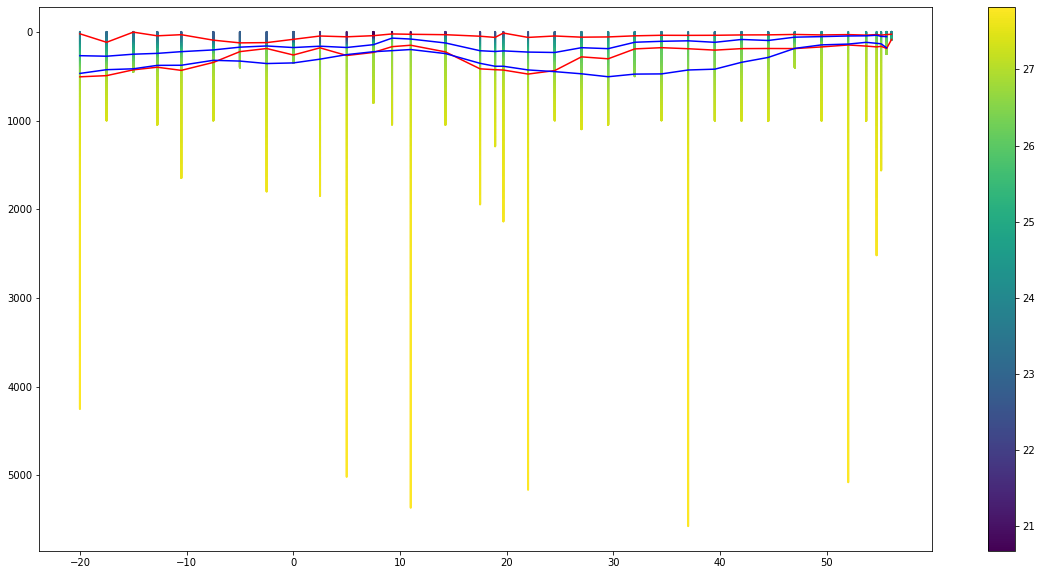

In [ ]:
from matplotlib import pyplot as plt

tcstart_depths = np.array([x["depth_cutoffs"][0] for x in station_to_tcstartend.values()])
tcend_depths = np.array([x["depth_cutoffs"][1] for x in station_to_tcstartend.values()])

old_tcstart_depths = np.array([x["old_depth_cutoffs"][0] for x in station_to_tcstartend.values()])
old_tcend_depths = np.array([x["old_depth_cutoffs"][1] for x in station_to_tcstartend.values()])

tc_lats = np.array([x["lat"] for x in station_to_tcstartend.values()])

#for plotting purposes, sort the bounds by latitude
argsort_lats = np.argsort(tc_lats)
tc_lats = tc_lats[argsort_lats]
tcstart_depths = tcstart_depths[argsort_lats]
tcend_depths = tcend_depths[argsort_lats]

old_tcstart_depths = old_tcstart_depths[argsort_lats]
old_tcend_depths = old_tcend_depths[argsort_lats]

plt.figure(figsize=(20,10))
plt.scatter(toplot_dataset["lat"], toplot_dataset["depth"],
            c=toplot_dataset["sig0"], s=1)
plt.colorbar()
plt.plot(tc_lats, tcstart_depths, color="red")
plt.plot(tc_lats, tcend_depths, color="red")
plt.plot(tc_lats, old_tcstart_depths, color="blue")
plt.plot(tc_lats, old_tcend_depths, color="blue")
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.show()





In [ ]:
#translate sig0 = 23.899 to depth space
depth_bound=[]
depth_bound_lat=[]
for stn in sorted(stn_to_data.keys()):
  stn_data = stn_to_data[stn]
  density = np.array(stn_data.sig0)
  depth = np.array(stn_data.depth)
  filtered_depth_vals = depth[density <= 23.899]
  if len(filtered_depth_vals) == 0:
    depth_threshold = np.min(depth) #or maybe some other sensible default
  else:
    depth_threshold = np.max(filtered_depth_vals)
  #print('station:', stn)
  #print('depth:', depth_threshold)
  depth_bound.append(depth_threshold)
  depth_bound_lat.append(stn_data.lat)

#organize depth above which there is no GLODAP data to array by lat
#C = np.vstack((depth_bound_lat, depth_bound)).T
no_data_depth = pd.DataFrame({'lat': depth_bound_lat,
           'depth': depth_bound})
argsort_depth_lats = np.argsort(no_data_depth['lat'])
depth_bound_lat = no_data_depth['lat'][argsort_depth_lats]
depth_bound = no_data_depth['depth'][argsort_depth_lats]

In [ ]:
#create cutoffs for sig0
tcstart_sig0 = np.array([x["sig0_cutoffs"][0] for x in station_to_tcstartend.values()])
tcend_sig0 = np.array([x["sig0_cutoffs"][1] for x in station_to_tcstartend.values()])
tcstart_sig0 = tcstart_sig0[argsort_lats]
tcend_sig0 = tcend_sig0[argsort_lats]
no_data=[23.899]
no_data_array=np.repeat(no_data, len(tc_lats))

(27.0, 20.0)

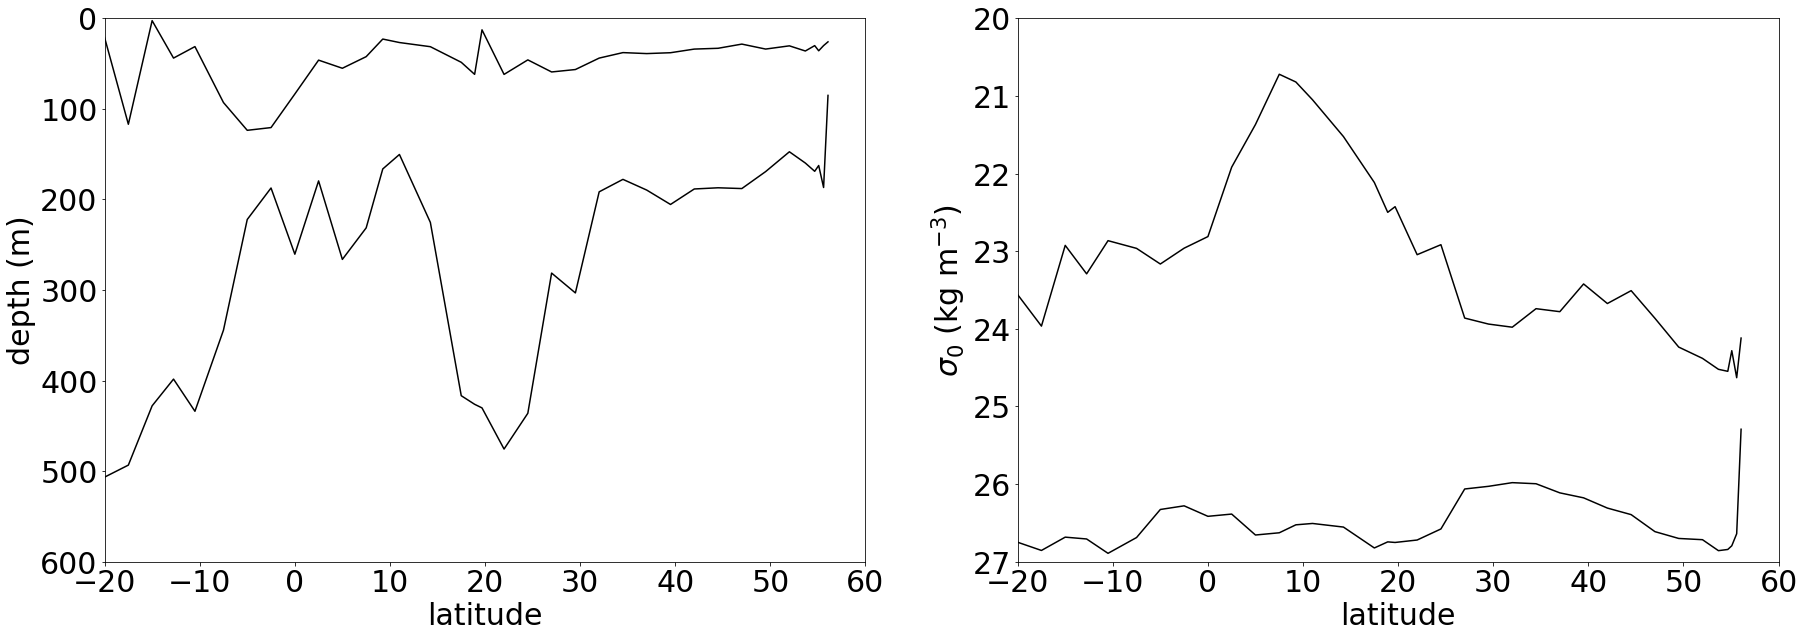

In [ ]:
#plot
import matplotlib.pyplot

matplotlib.pyplot.rcParams.update({'font.size': 30})

fig = matplotlib.pyplot.figure(figsize=(30.0, 10.0))

axes1 = fig.add_subplot(1, 2, 1)
axes2 = fig.add_subplot(1, 2, 2)

#first plot
axes1.set_ylabel('depth (m)')
axes1.set_xlabel('latitude')
axes1.plot(tc_lats, tcstart_depths, color="black")
axes1.plot(tc_lats, tcend_depths, color="black")
axes1.set_xlim(-20,60)
axes1.set_ylim(600,0)

#second plot
axes2.set_ylabel('$σ_0$ (kg m$^{-3}$)')
axes2.set_xlabel('latitude')
axes2.plot(tc_lats, tcstart_sig0, color="black")
axes2.plot(tc_lats, tcend_sig0, color="black")
axes2.set_xlim(-20,60)
axes2.set_ylim(27,20)